### Import all the necessary library

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from typing import Union, Dict, Any, Tuple, List
import matplotlib.pyplot as plt
import json
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve
)
import time
import os
from decision_tree import DecisionTreeClassifier
from naive_bayes import NaiveBayesClassifier


In [2]:
warnings.filterwarnings('ignore')

In [3]:
def create_benchmarks_directory():
    """
    Create a benchmarks directory if it doesn't exist.
    
    Returns:
    str: Path to the benchmarks directory
    """
    benchmarks_dir = 'benchmarks'
    if not os.path.exists(benchmarks_dir):
        os.makedirs(benchmarks_dir)
        print(f"Created directory: {benchmarks_dir}")
    return benchmarks_dir


In [4]:
def load_dataset_from_uci(id: int) -> Tuple[pd.DataFrame, Union[pd.DataFrame, pd.Series, np.ndarray]]:
    """
    Fetch a dataset from the UCI Machine Learning Repository by its ID.
    
    Parameters:
    id (int): The ID of the dataset to fetch.
    
    Returns:
    Tuple[pd.DataFrame, Union[pd.DataFrame, pd.Series, np.ndarray]]: A tuple containing the features as a DataFrame and the targets as a DataFrame, Series, or NumPy array.
    """
    repo = fetch_ucirepo(id=id)
    
    # Check if features and targets are None
    if repo.data.features is None:
        raise ValueError(f"Dataset {id}: Features data is None")
    if repo.data.targets is None:
        raise ValueError(f"Dataset {id}: Targets data is None")
    
    return repo.data.features, repo.data.targets


In [5]:
def preprocess_data(X: pd.DataFrame, y: Union[pd.DataFrame, pd.Series, np.ndarray]) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Preprocess the dataset by handling missing values and encoding categorical variables.
    
    Parameters:
    X (pd.DataFrame): Feature dataset
    y (Union[pd.DataFrame, pd.Series, np.ndarray]): Target variable
    
    Returns:
    Tuple[pd.DataFrame, pd.Series]: Preprocessed features and target
    """
    # Convert y to Series if it's a DataFrame
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]
    elif isinstance(y, np.ndarray):
        y = pd.Series(y)
    
    # Reset indices to ensure alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # Handle missing values
    # For numerical columns, fill with median
    numerical_cols = X.select_dtypes(include=[np.number]).columns
    X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())
    
    # For categorical columns, fill with mode
    categorical_cols = X.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 'Unknown')
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    # Encode target variable if it's categorical
    if y.dtype == 'object' or not np.issubdtype(y.dtype, np.number):
        le_target = LabelEncoder()
        y = pd.Series(le_target.fit_transform(y.astype(str)))
    
    return X, y


In [6]:
def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray = None) -> Dict[str, float]:
    """
    Calculate various classification metrics.
    
    Parameters:
    y_true (np.ndarray): True labels
    y_pred (np.ndarray): Predicted labels
    y_prob (np.ndarray, optional): Predicted probabilities for AUC calculation
    
    Returns:
    Dict[str, float]: Dictionary containing various metrics
    """
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['recall'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    # AUC calculation
    try:
        unique_classes = np.unique(y_true)
        if len(unique_classes) == 2 and y_prob is not None:
            # Binary classification with probabilities
            metrics['auc'] = roc_auc_score(y_true, y_prob[:, 1] if y_prob.ndim > 1 else y_prob)
        elif len(unique_classes) > 2 and y_prob is not None:
            # Multi-class classification with probabilities
            metrics['auc'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
        elif len(unique_classes) == 2:
            # Binary classification without probabilities - use predictions as scores
            metrics['auc'] = roc_auc_score(y_true, y_pred)
        else:
            # Multi-class without probabilities - AUC not meaningful
            metrics['auc'] = 0.0
    except Exception:
        metrics['auc'] = 0.0
    
    return metrics


In [7]:
def calculate_confusion_stats(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, int]:
    """
    Calculate TP, TN, FP, FN for a binary classification problem.
    For multi-class, treats each class as one-vs-rest.
    
    Parameters:
    y_true (np.ndarray): True labels
    y_pred (np.ndarray): Predicted labels
    
    Returns:
    Dict[str, Dict[str, int]]: Dictionary with confusion matrix stats for each class
    """
    classes = np.unique(y_true)
    result = {}
    
    for cls in classes:
        # Create binary classification problem (one-vs-rest)
        y_true_binary = (y_true == cls).astype(int)
        y_pred_binary = (y_pred == cls).astype(int)
        
        # Calculate metrics
        TP = np.sum((y_true_binary == 1) & (y_pred_binary == 1))
        TN = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
        FP = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
        FN = np.sum((y_true_binary == 1) & (y_pred_binary == 0))
        
        # Calculate precision, recall, and f1 for this class
        accuracy_score = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        auc = (recall + specificity) / 2
        
        result[cls] = {
            'TP': int(TP),
            'TN': int(TN),
            'FP': int(FP),
            'FN': int(FN),
            'precision': float(precision),
            'recall': float(recall),
            'f1': float(f1),
            'accuracy': float(accuracy_score),
            'specificity': float(specificity),
            'auc': float(auc)
        }
    
    return result


In [8]:
def train_and_evaluate_model(model, X_train: pd.DataFrame, X_test: pd.DataFrame, 
                           y_train: pd.Series, y_test: pd.Series) -> Tuple[Dict[str, float], float, float, Dict[str, Any]]:
    """
    Train and evaluate a single model.
    
    Parameters:
    model: The classifier instance
    X_train, X_test: Training and testing features
    y_train, y_test: Training and testing targets
    
    Returns:
    Tuple[Dict[str, float], float, float, Dict[str, Any]]: Metrics dictionary, training time, inference time, and prediction data
    """
    # Train the model
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Make predictions and measure inference time
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time
    
    # Get probabilities if available (include in inference time)
    y_prob = None
    if hasattr(model, 'predict_proba'):
        try:
            prob_start_time = time.time()
            y_prob = model.predict_proba(X_test)
            inference_time += time.time() - prob_start_time
        except Exception:
            y_prob = None
    
    # Calculate metrics
    metrics = calculate_metrics(y_test.values, y_pred, y_prob)
    
    # Calculate confusion matrix stats with class-specific metrics
    confusion_stats = calculate_confusion_stats(y_test.values, y_pred)
    
    # Store prediction data for plotting
    prediction_data = {
        'y_true': y_test.values,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'n_classes': len(y_train.unique()),
        'confusion_stats': confusion_stats,
        'classes': np.unique(y_test.values)
    }
    
    return metrics, training_time, inference_time, prediction_data


In [9]:
def load_and_preprocess_data(dataset_id: int) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Load and preprocess the dataset from UCI.
    
    Parameters:
    dataset_id (int): The ID of the dataset to fetch and preprocess.
    
    Returns:
    Tuple[pd.DataFrame, pd.Series]: A tuple containing the preprocessed features and target variable.
    """
    # Load data
    X, y = load_dataset_from_uci(dataset_id)
    
    # Preprocess data
    X, y = preprocess_data(X, y)
    
    return X, y

In [10]:
def benchmark_dataset(dataset_name: str, dataset_id: int) -> Dict[str, Any]:
    """
    Benchmark both classifiers on a single dataset.
    
    Parameters:
    dataset_name (str): Name of the dataset
    dataset_id (int): UCI repository ID of the dataset
    
    Returns:
    Dict[str, Any]: Benchmark results for the dataset
    """
    print(f"\n{'='*50}")
    print(f"Benchmarking dataset: {dataset_name} (ID: {dataset_id})")
    print(f"{'='*50}")
    
    try:
        # Load and preprocess data
        X, y = load_and_preprocess_data(dataset_id)
        
        print(f"Dataset shape: {X.shape}")
        print(f"Number of classes: {len(y.unique())}")
        print(f"Class distribution:\n{y.value_counts()}")
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        results = {
            'dataset_name': dataset_name,
            'dataset_id': dataset_id,
            'n_samples': len(X),
            'n_features': X.shape[1],
            'n_classes': len(y.unique()),
            'models': {}
        }
        
        # Initialize models
        models = {
            'Decision Tree': DecisionTreeClassifier(max_depth=10),
            'Naive Bayes': NaiveBayesClassifier(alpha=1.0)
        }
        
        # Evaluate each model
        for model_name, model in models.items():
            print(f"\nEvaluating {model_name}...")
            try:
                metrics, training_time, inference_time, prediction_data = train_and_evaluate_model(
                    model, X_train, X_test, y_train, y_test
                )
                
                results['models'][model_name] = {
                    'metrics': metrics,
                    'training_time': training_time,
                    'inference_time': inference_time,
                    'prediction_data': prediction_data
                }
                
                print(f"{model_name} Results:")
                print(f"  Accuracy: {metrics['accuracy']:.4f}")
                print(f"  Precision: {metrics['precision']:.4f}")
                print(f"  Recall: {metrics['recall']:.4f}")
                print(f"  F1-Score: {metrics['f1_score']:.4f}")
                print(f"  AUC: {metrics['auc']:.4f}")
                print(f"  Training Time: {training_time:.4f} seconds")
                print(f"  Inference Time: {inference_time:.4f} seconds")
            
            except Exception as e:
                print(f"Error evaluating {model_name}: {str(e)}")
                results['models'][model_name] = {
                    'metrics': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'auc': 0},
                    'training_time': 0,
                    'inference_time': 0,
                    'prediction_data': None,
                    'error': str(e)
                }
        
        return results
        
    except Exception as e:
        print(f"Error processing dataset {dataset_name}: {str(e)}")
        return {
            'dataset_name': dataset_name,
            'dataset_id': dataset_id,
            'error': str(e),
            'models': {}
        }


In [11]:
def benchmark_dataset_random_split(dataset_name: str, dataset_id: int, n_splits: int = 5) -> Dict[str, Any]:
    """
    Benchmark both classifiers on a single dataset with multiple data splits.
    
    Parameters:
    dataset_name (str): Name of the dataset
    dataset_id (int): UCI repository ID of the dataset
    n_splits (int): Number of different data splits to try
    
    Returns:
    Dict[str, Any]: Benchmark results for the dataset (best performance)
    """
    print(f"\n{'='*50}")
    print(f"Benchmarking dataset: {dataset_name} (ID: {dataset_id})")
    print(f"{'='*50}")
    
    try:
        # Load and preprocess data
        X, y = load_and_preprocess_data(dataset_id)
        
        print(f"Dataset shape: {X.shape}")
        print(f"Number of classes: {len(y.unique())}")
        print(f"Class distribution:\n{y.value_counts()}")
        
        # Initialize result dictionaries for each model
        dt_results = []
        nb_results = []
        
        # Initialize models
        models = {
            'Decision Tree': DecisionTreeClassifier(max_depth=10),
            'Naive Bayes': NaiveBayesClassifier(alpha=1.0)
        }
        
        # Perform multiple data splits and evaluations
        for split_idx in range(n_splits):
            print(f"\nSplit {split_idx+1}/{n_splits}:")
            
            # Split the data with different random seeds
            random_seed = 42 + split_idx
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.15, random_state=random_seed, stratify=y
            )
            
            split_results = {}
            
            # Evaluate each model
            for model_name, model in models.items():
                print(f"  Evaluating {model_name}...")
                try:
                    metrics, training_time, inference_time, prediction_data = train_and_evaluate_model(
                        model, X_train, X_test, y_train, y_test
                    )
                    
                    result = {
                        'metrics': metrics,
                        'training_time': training_time,
                        'inference_time': inference_time,
                        'prediction_data': prediction_data,
                        'split_idx': split_idx,
                        'random_seed': random_seed
                    }
                    
                    # Store results for this split
                    if model_name == 'Decision Tree':
                        dt_results.append(result)
                    else:
                        nb_results.append(result)
                    
                    split_results[model_name] = result
                    
                    print(f"  {model_name} Results (Split {split_idx+1}):")
                    print(f"    Accuracy: {metrics['accuracy']:.4f}")
                    print(f"    Precision: {metrics['precision']:.4f}")
                    print(f"    Recall: {metrics['recall']:.4f}")
                    print(f"    F1-Score: {metrics['f1_score']:.4f}")
                    print(f"    AUC: {metrics['auc']:.4f}")
                
                except Exception as e:
                    print(f"    Error evaluating {model_name} on split {split_idx+1}: {str(e)}")
                    # Add empty result for this split
                    empty_result = {
                        'metrics': {'accuracy': 0, 'precision': 0, 'recall': 0, 'f1_score': 0, 'auc': 0},
                        'training_time': 0,
                        'inference_time': 0,
                        'prediction_data': None,
                        'error': str(e),
                        'split_idx': split_idx,
                        'random_seed': random_seed
                    }
                    
                    if model_name == 'Decision Tree':
                        dt_results.append(empty_result)
                    else:
                        nb_results.append(empty_result)
        
        # Find the best performing split for each model (based on accuracy)
        best_dt_idx = max(range(len(dt_results)), 
                           key=lambda i: dt_results[i]['metrics']['accuracy']) if dt_results else -1
        best_nb_idx = max(range(len(nb_results)), 
                           key=lambda i: nb_results[i]['metrics']['accuracy']) if nb_results else -1
        
        # Build the final results dictionary
        results = {
            'dataset_name': dataset_name,
            'dataset_id': dataset_id,
            'n_samples': len(X),
            'n_features': X.shape[1],
            'n_classes': len(y.unique()),
            'n_splits': n_splits,
            'models': {}
        }
        
        # Add best results for each model
        if best_dt_idx >= 0:
            best_dt = dt_results[best_dt_idx]
            results['models']['Decision Tree'] = {
                'metrics': best_dt['metrics'],
                'training_time': best_dt['training_time'],
                'inference_time': best_dt['inference_time'],
                'prediction_data': best_dt['prediction_data'],
                'best_split_idx': best_dt['split_idx'],
                'best_random_seed': best_dt['random_seed']
            }
            
            print(f"\nBest Decision Tree result (Split {best_dt['split_idx']+1}):")
            print(f"  Accuracy: {best_dt['metrics']['accuracy']:.4f}")
            print(f"  Precision: {best_dt['metrics']['precision']:.4f}")
            print(f"  Recall: {best_dt['metrics']['recall']:.4f}")
            print(f"  F1-Score: {best_dt['metrics']['f1_score']:.4f}")
            print(f"  AUC: {best_dt['metrics']['auc']:.4f}")
            print(f"  Training Time: {best_dt['training_time']:.4f} seconds")
            print(f"  Inference Time: {best_dt['inference_time']:.4f} seconds")
        
        if best_nb_idx >= 0:
            best_nb = nb_results[best_nb_idx]
            results['models']['Naive Bayes'] = {
                'metrics': best_nb['metrics'],
                'training_time': best_nb['training_time'],
                'inference_time': best_nb['inference_time'],
                'prediction_data': best_nb['prediction_data'],
                'best_split_idx': best_nb['split_idx'],
                'best_random_seed': best_nb['random_seed']
            }
            
            print(f"\nBest Naive Bayes result (Split {best_nb['split_idx']+1}):")
            print(f"  Accuracy: {best_nb['metrics']['accuracy']:.4f}")
            print(f"  Precision: {best_nb['metrics']['precision']:.4f}")
            print(f"  Recall: {best_nb['metrics']['recall']:.4f}")
            print(f"  F1-Score: {best_nb['metrics']['f1_score']:.4f}")
            print(f"  AUC: {best_nb['metrics']['auc']:.4f}")
            print(f"  Training Time: {best_nb['training_time']:.4f} seconds")
            print(f"  Inference Time: {best_nb['inference_time']:.4f} seconds")
        
        # Also store all splits data for potential analysis
        results['all_splits'] = {
            'Decision Tree': dt_results,
            'Naive Bayes': nb_results
        }
        
        return results
        
    except Exception as e:
        print(f"Error processing dataset {dataset_name}: {str(e)}")
        return {
            'dataset_name': dataset_name,
            'dataset_id': dataset_id,
            'error': str(e),
            'models': {}
        }

In [12]:
def create_comparison_plots(all_results: List[Dict[str, Any]]):
    """
    Create visualization plots comparing the two algorithms.
    
    Parameters:
    all_results (List[Dict[str, Any]]): Results from all datasets
    """
    # Filter out results with errors
    valid_results = [r for r in all_results if 'error' not in r and r['models']]
    
    if not valid_results:
        print("No valid results to plot.")
        return
    
    # Prepare data for plotting
    datasets = []
    dt_accuracies = []
    nb_accuracies = []
    dt_f1_scores = []
    nb_f1_scores = []
    dt_times = []
    nb_times = []
    
    for result in valid_results:
        if 'Decision Tree' in result['models'] and 'Naive Bayes' in result['models']:
            datasets.append(result['dataset_name'])
            
            dt_metrics = result['models']['Decision Tree']['metrics']
            nb_metrics = result['models']['Naive Bayes']['metrics']
            
            dt_accuracies.append(dt_metrics['accuracy'])
            nb_accuracies.append(nb_metrics['accuracy'])
            dt_f1_scores.append(dt_metrics['f1_score'])
            nb_f1_scores.append(nb_metrics['f1_score'])
            dt_times.append(result['models']['Decision Tree']['training_time'])
            nb_times.append(result['models']['Naive Bayes']['training_time'])
    
    if not datasets:
        print("No complete results to plot.")
        return
    
    # Create subplots with improved spacing
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Decision Tree vs Naive Bayes Comparison', fontsize=18, y=0.98)
    
    # Accuracy comparison
    x = np.arange(len(datasets))
    width = 0.35
    
    axes[0, 0].bar(x - width/2, dt_accuracies, width, label='Decision Tree', alpha=0.8)
    axes[0, 0].bar(x + width/2, nb_accuracies, width, label='Naive Bayes', alpha=0.8)
    axes[0, 0].set_xlabel('Datasets', fontsize=11)
    axes[0, 0].set_ylabel('Accuracy', fontsize=11)
    axes[0, 0].set_title('Accuracy Comparison', fontsize=12)
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(datasets, rotation=45, ha='right', fontsize=9)
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    
    # F1-Score comparison
    axes[0, 1].bar(x - width/2, dt_f1_scores, width, label='Decision Tree', alpha=0.8)
    axes[0, 1].bar(x + width/2, nb_f1_scores, width, label='Naive Bayes', alpha=0.8)
    axes[0, 1].set_xlabel('Datasets', fontsize=11)
    axes[0, 1].set_ylabel('F1-Score', fontsize=11)
    axes[0, 1].set_title('F1-Score Comparison', fontsize=12)
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(datasets, rotation=45, ha='right', fontsize=9)
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Training time comparison
    axes[1, 0].bar(x - width/2, dt_times, width, label='Decision Tree', alpha=0.8)
    axes[1, 0].bar(x + width/2, nb_times, width, label='Naive Bayes', alpha=0.8)
    axes[1, 0].set_xlabel('Datasets', fontsize=11)
    axes[1, 0].set_ylabel('Training Time (seconds)', fontsize=11)
    axes[1, 0].set_title('Training Time Comparison', fontsize=12)
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(datasets, rotation=45, ha='right', fontsize=9)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Scatter plot: Accuracy vs F1-Score
    axes[1, 1].scatter(dt_accuracies, dt_f1_scores, label='Decision Tree', alpha=0.7, s=100)
    axes[1, 1].scatter(nb_accuracies, nb_f1_scores, label='Naive Bayes', alpha=0.7, s=100)
    axes[1, 1].set_xlabel('Accuracy', fontsize=11)
    axes[1, 1].set_ylabel('F1-Score', fontsize=11)
    axes[1, 1].set_title('Accuracy vs F1-Score', fontsize=12)
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    
    # Adjust spacing to prevent overlap
    plt.subplots_adjust(
        left=0.08,      # left margin
        bottom=0.15,    # bottom margin for rotated labels
        right=0.95,     # right margin
        top=0.92,       # top margin (below suptitle)
        wspace=0.3,     # width spacing between subplots
        hspace=0.4      # height spacing between subplots
    )
    
    # Create benchmarks directory
    benchmarks_dir = create_benchmarks_directory()
    
    # Save plots with timestamp
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_filename = os.path.join(benchmarks_dir, f'classifier_comparison.png')
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
    print(f"Comparison plots saved to '{plot_filename}'")
    plt.show()
    
    # Also save individual metric plots with improved spacing
    fig2, ax = plt.subplots(figsize=(14, 10))
    
    # Create a heatmap-style comparison
    x_pos = np.arange(len(datasets))
    width = 0.2
    
    ax.bar(x_pos - width*1.5, dt_accuracies, width, label='DT Accuracy', alpha=0.8)
    ax.bar(x_pos - width*0.5, nb_accuracies, width, label='NB Accuracy', alpha=0.8)
    ax.bar(x_pos + width*0.5, dt_f1_scores, width, label='DT F1-Score', alpha=0.8)
    ax.bar(x_pos + width*1.5, nb_f1_scores, width, label='NB F1-Score', alpha=0.8)
    
    ax.set_xlabel('Datasets', fontsize=12)
    ax.set_ylabel('Performance Score', fontsize=12)
    ax.set_title('Comprehensive Performance Comparison', fontsize=14, pad=20)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=10)
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Adjust margins for better spacing
    plt.subplots_adjust(bottom=0.20, top=0.92, left=0.10, right=0.95)
    
    detailed_plot_filename = os.path.join(benchmarks_dir, f'detailed_comparison.png')
    plt.savefig(detailed_plot_filename, dpi=300, bbox_inches='tight')
    print(f"Detailed comparison plot saved to '{detailed_plot_filename}'")
    plt.show()



In [13]:
def create_roc_plots(all_results: List[Dict[str, Any]]):
    """
    Create ROC curve plots comparing the two algorithms for each dataset.
    
    Parameters:
    all_results (List[Dict[str, Any]]): Results from all datasets
    """
    # Filter out results with errors and valid prediction data
    valid_results = []
    binary_results = []
    
    for result in all_results:
        if ('error' not in result and result['models'] and 
            'Decision Tree' in result['models'] and 'Naive Bayes' in result['models']):
            
            dt_data = result['models']['Decision Tree'].get('prediction_data')
            nb_data = result['models']['Naive Bayes'].get('prediction_data')
            
            if (dt_data and nb_data and 
                dt_data.get('y_prob') is not None and nb_data.get('y_prob') is not None):
                valid_results.append(result)
                
                # Check if it's binary classification for proper ROC curves
                if dt_data.get('n_classes', 0) == 2:
                    binary_results.append(result)
    
    if not valid_results:
        print("No valid results with probabilities for ROC plotting.")
        return
    
    # Create benchmarks directory
    benchmarks_dir = create_benchmarks_directory()
    import datetime
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
      # Plot ROC curves for binary classification datasets
    if binary_results:
        n_binary = len(binary_results)
        cols = min(3, n_binary)
        rows = (n_binary + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
        
        # Handle different subplot configurations
        if n_binary == 1:
            axes = [axes]  # Single subplot case
        elif rows == 1 and cols > 1:
            axes = [axes]  # Single row, multiple columns
        elif cols == 1 and rows > 1:
            axes = [[ax] for ax in axes]  # Single column, multiple rows
        elif rows > 1 and cols > 1:
            pass  # Already in correct 2D format
        
        fig.suptitle('ROC Curves Comparison - Binary Classification Datasets', fontsize=16)
        
        for idx, result in enumerate(binary_results):
            row = idx // cols
            col = idx % cols
            
            # Get the correct axis
            if n_binary == 1:
                ax = axes[0]
            elif rows == 1:
                ax = axes[0][col] if isinstance(axes[0], (list, np.ndarray)) else axes[col]
            elif cols == 1:
                ax = axes[row][0]
            else:
                ax = axes[row][col]
            
            dataset_name = result['dataset_name']
            
            # Get prediction data
            dt_data = result['models']['Decision Tree']['prediction_data']
            nb_data = result['models']['Naive Bayes']['prediction_data']
            
            # Calculate ROC curves for Decision Tree
            dt_fpr, dt_tpr, _ = roc_curve(dt_data['y_true'], dt_data['y_prob'][:, 1])
            dt_auc = result['models']['Decision Tree']['metrics']['auc']
            
            # Calculate ROC curves for Naive Bayes
            nb_fpr, nb_tpr, _ = roc_curve(nb_data['y_true'], nb_data['y_prob'][:, 1])
            nb_auc = result['models']['Naive Bayes']['metrics']['auc']
            
            # Plot ROC curves
            ax.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.3f})', 
                   linewidth=2, alpha=0.8)
            ax.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.3f})', 
                   linewidth=2, alpha=0.8)
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
            
            ax.set_xlabel('False Positive Rate', fontsize=10)
            ax.set_ylabel('True Positive Rate', fontsize=10)
            ax.set_title(f'{dataset_name}', fontsize=11)
            ax.legend(fontsize=9)
            ax.grid(True, alpha=0.3)
            ax.set_xlim([0, 1])
            ax.set_ylim([0, 1])
          # Hide empty subplots
        total_subplots = rows * cols
        for idx in range(n_binary, total_subplots):
            row = idx // cols
            col = idx % cols
            
            # Get the correct axis for hiding
            if n_binary == 1:
                continue  # No empty subplots if only one
            elif rows == 1:
                ax = axes[0][col] if isinstance(axes[0], (list, np.ndarray)) else axes[col]
            elif cols == 1:
                ax = axes[row][0]
            else:
                ax = axes[row][col]
            ax.set_visible(False)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        
        # Save binary ROC plots
        roc_binary_filename = os.path.join(benchmarks_dir, f'roc_curves_binary.png')
        plt.savefig(roc_binary_filename, dpi=300, bbox_inches='tight')
        print(f"Binary ROC curves saved to '{roc_binary_filename}'")
        plt.show()
    
    # Create a summary ROC plot showing average performance
    if binary_results:
        fig, ax = plt.subplots(figsize=(10, 8))
        
        dt_aucs = []
        nb_aucs = []
        dataset_names = []
        
        for result in binary_results:
            dt_aucs.append(result['models']['Decision Tree']['metrics']['auc'])
            nb_aucs.append(result['models']['Naive Bayes']['metrics']['auc'])
            dataset_names.append(result['dataset_name'])
        
        # Create AUC comparison bar plot
        x = np.arange(len(dataset_names))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, dt_aucs, width, label='Decision Tree', alpha=0.8, color='skyblue')
        bars2 = ax.bar(x + width/2, nb_aucs, width, label='Naive Bayes', alpha=0.8, color='lightcoral')
        
        # Add value labels on bars
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        ax.set_xlabel('Datasets', fontsize=12)
        ax.set_ylabel('AUC Score', fontsize=12)
        ax.set_title('AUC Comparison - Binary Classification Datasets', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(dataset_names, rotation=45, ha='right', fontsize=10)
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([0, 1.1])
        
        plt.tight_layout()
        
        # Save AUC comparison plot
        auc_comparison_filename = os.path.join(benchmarks_dir, f'auc_comparison.png')
        plt.savefig(auc_comparison_filename, dpi=300, bbox_inches='tight')
        print(f"AUC comparison plot saved to '{auc_comparison_filename}'")
        plt.show()
    
    # Handle multi-class datasets (show AUC scores instead of ROC curves)
    multiclass_results = [r for r in valid_results if r not in binary_results]
    if multiclass_results:
        print(f"\nNote: {len(multiclass_results)} multi-class datasets found.")
        print("ROC curves for multi-class are complex - showing AUC scores in summary instead.")
        
        # Create multi-class AUC comparison
        fig, ax = plt.subplots(figsize=(12, 8))
        
        mc_dt_aucs = []
        mc_nb_aucs = []
        mc_dataset_names = []
        
        for result in multiclass_results:
            mc_dt_aucs.append(result['models']['Decision Tree']['metrics']['auc'])
            mc_nb_aucs.append(result['models']['Naive Bayes']['metrics']['auc'])
            mc_dataset_names.append(result['dataset_name'])
        
        if mc_dt_aucs:  # Only plot if there are multi-class results
            x = np.arange(len(mc_dataset_names))
            width = 0.35
            
            bars1 = ax.bar(x - width/2, mc_dt_aucs, width, label='Decision Tree', alpha=0.8, color='lightgreen')
            bars2 = ax.bar(x + width/2, mc_nb_aucs, width, label='Naive Bayes', alpha=0.8, color='orange')
            
            # Add value labels on bars
            for bar in bars1:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)
            
            for bar in bars2:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=9)
            
            ax.set_xlabel('Datasets', fontsize=12)
            ax.set_ylabel('AUC Score (Multi-class OvR)', fontsize=12)
            ax.set_title('AUC Comparison - Multi-class Datasets', fontsize=14)
            ax.set_xticks(x)
            ax.set_xticklabels(mc_dataset_names, rotation=45, ha='right', fontsize=10)
            ax.legend(fontsize=11)
            ax.grid(True, alpha=0.3, axis='y')
            
            plt.tight_layout()
            
            # Save multi-class AUC comparison plot
            mc_auc_filename = os.path.join(benchmarks_dir, f'multiclass_auc_comparison_{timestamp}.png')
            plt.savefig(mc_auc_filename, dpi=300, bbox_inches='tight')
            print(f"Multi-class AUC comparison plot saved to '{mc_auc_filename}'")
            plt.show()


In [14]:
def generate_summary_report(all_results: List[Dict[str, Any]]) -> pd.DataFrame:
    """
    Generate a summary report of all benchmark results.
    
    Parameters:
    all_results (List[Dict[str, Any]]): Results from all datasets
    
    Returns:
    pd.DataFrame: Summary report as a DataFrame
    """
    summary_data = []
    
    for result in all_results:
        if 'error' in result:
            continue
            
        row = {
            'Dataset': result['dataset_name'],
            'Samples': result.get('n_samples', 0),
            'Features': result.get('n_features', 0),
            'Classes': result.get('n_classes', 0)
        }
        
        for model_name in ['Decision Tree', 'Naive Bayes']:
            if model_name in result['models']:
                model_data = result['models'][model_name]
                prefix = 'DT_' if model_name == 'Decision Tree' else 'NB_'
                
                if 'metrics' in model_data:
                    metrics = model_data['metrics']
                    row[f'{prefix}Accuracy'] = metrics.get('accuracy', 0)
                    row[f'{prefix}Precision'] = metrics.get('precision', 0)
                    row[f'{prefix}Recall'] = metrics.get('recall', 0)
                    row[f'{prefix}F1_Score'] = metrics.get('f1_score', 0)
                    row[f'{prefix}AUC'] = metrics.get('auc', 0)
                    row[f'{prefix}Time'] = model_data.get('training_time', 0)
        
        summary_data.append(row)
    
    df = pd.DataFrame(summary_data)
    return df

In [15]:
def print_confusion_stats_tables(all_results: List[Dict[str, Any]]):
    """
    Print confusion matrix statistics and per-class metrics as tables
    
    Parameters:
    all_results (List[Dict[str, Any]]): Results from all datasets
    """
    valid_results = [r for r in all_results if 'error' not in r and r['models']]
    
    if not valid_results:
        print("No valid results to display confusion statistics.")
        return
    
    print("\n" + "="*80)
    print("CLASS-SPECIFIC METRICS AND CONFUSION MATRIX STATISTICS")
    print("="*80)
    
    for result in valid_results:
        dataset_name = result['dataset_name']
        print(f"\nDataset: {dataset_name}")
        print("-" * 80)
        
        # Get prediction data with confusion stats
        dt_data = result['models']['Decision Tree']['prediction_data']
        nb_data = result['models']['Naive Bayes']['prediction_data']
        
        dt_confusion = dt_data['confusion_stats']
        nb_confusion = nb_data['confusion_stats']
        classes = sorted(dt_confusion.keys())
        
        # Create DataFrame for each class
        for cls in classes:
            print(f"\nClass {cls} vs Rest:")
            print("-" * 40)
            
            # Create DataFrame to display metrics side by side
                        # ...existing code...
            data = [
                [
                    "Decision Tree", 
                    dt_confusion[cls]['TP'], dt_confusion[cls]['TN'], 
                    dt_confusion[cls]['FP'], dt_confusion[cls]['FN'],
                    dt_confusion[cls]['precision'], dt_confusion[cls]['recall'], 
                    dt_confusion[cls]['f1'], dt_confusion[cls]['accuracy'], dt_confusion[cls]['auc']
                ],
                [
                    "Naive Bayes", 
                    nb_confusion[cls]['TP'], nb_confusion[cls]['TN'], 
                    nb_confusion[cls]['FP'], nb_confusion[cls]['FN'],
                    nb_confusion[cls]['precision'], nb_confusion[cls]['recall'], 
                    nb_confusion[cls]['f1'], nb_confusion[cls]['accuracy'], nb_confusion[cls]['auc']
                ]
            ]
            # ...existing code...
            
            df = pd.DataFrame(data, columns=[
                "Model", "TP", "TN", "FP", "FN", 
                "Precision", "Recall", "F1-Score", "Accuracy", "AUC"
            ])
            
            print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}" if isinstance(x, float) else str(x)))
    
    print("\n" + "="*80)


In [16]:
def create_metrics_plots(all_results: List[Dict[str, Any]]):
    """
    Create plots for accuracy, precision, recall, and F1 score metrics.
    
    Parameters:
    all_results (List[Dict[str, Any]]): Results from all datasets
    """
    valid_results = [r for r in all_results if 'error' not in r and r['models']]
    
    if not valid_results:
        print("No valid results to plot metrics.")
        return
    
    # Create benchmarks directory
    benchmarks_dir = create_benchmarks_directory()
    
    # Setup data for plotting
    metrics_by_dataset = {}
    class_metrics_by_dataset = {}
    
    for result in valid_results:
        dataset_name = result['dataset_name']
        metrics_by_dataset[dataset_name] = {
            'Decision Tree': {
                'accuracy': result['models']['Decision Tree']['metrics']['accuracy'],
                'precision': result['models']['Decision Tree']['metrics']['precision'],
                'recall': result['models']['Decision Tree']['metrics']['recall'],
                'f1_score': result['models']['Decision Tree']['metrics']['f1_score'],
                'auc': result['models']['Decision Tree']['metrics']['auc']
            },
            'Naive Bayes': {
                'accuracy': result['models']['Naive Bayes']['metrics']['accuracy'],
                'precision': result['models']['Naive Bayes']['metrics']['precision'],
                'recall': result['models']['Naive Bayes']['metrics']['recall'],
                'f1_score': result['models']['Naive Bayes']['metrics']['f1_score'],
                'auc': result['models']['Naive Bayes']['metrics']['auc']
            }
        }
        
        # Extract class-specific metrics
        class_metrics_by_dataset[dataset_name] = {
            'Decision Tree': result['models']['Decision Tree']['prediction_data']['confusion_stats'],
            'Naive Bayes': result['models']['Naive Bayes']['prediction_data']['confusion_stats']
        }
    
    # Create multi-metric comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(18, 16))
    fig.suptitle('Metric Comparison: Decision Tree vs Naive Bayes', fontsize=18, y=0.98)
    
    metric_names = ['accuracy', 'precision', 'recall', 'f1_score']
    metric_titles = ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1 Score (Weighted)']
    
    for idx, (metric, title) in enumerate(zip(metric_names, metric_titles)):
        row = idx // 2
        col = idx % 2
        
        datasets = list(metrics_by_dataset.keys())
        dt_values = [metrics_by_dataset[d]['Decision Tree'][metric] for d in datasets]
        nb_values = [metrics_by_dataset[d]['Naive Bayes'][metric] for d in datasets]
        
        x = np.arange(len(datasets))
        width = 0.35
        
        axes[row, col].bar(x - width/2, dt_values, width, label='Decision Tree', alpha=0.8)
        axes[row, col].bar(x + width/2, nb_values, width, label='Naive Bayes', alpha=0.8)
        axes[row, col].set_xlabel('Datasets', fontsize=11)
        axes[row, col].set_ylabel(title, fontsize=11)
        axes[row, col].set_title(f'{title} Comparison', fontsize=12)
        axes[row, col].set_xticks(x)
        axes[row, col].set_xticklabels(datasets, rotation=45, ha='right', fontsize=9)
        axes[row, col].legend(fontsize=10)
        axes[row, col].grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    metrics_plot_filename = os.path.join(benchmarks_dir, 'metrics_comparison.png')
    plt.savefig(metrics_plot_filename, dpi=300, bbox_inches='tight')
    print(f"Metrics comparison plot saved to '{metrics_plot_filename}'")
    plt.show()
    
    # Create per-class metric plots for each dataset
    for dataset_name, dataset_metrics in class_metrics_by_dataset.items():
        dt_metrics = dataset_metrics['Decision Tree']
        nb_metrics = dataset_metrics['Naive Bayes']
        
        classes = sorted(dt_metrics.keys())
        
        # Create one figure per dataset for class-specific metrics
        fig, axes = plt.subplots(3, 2, figsize=(18, 20))
        axes = axes.flatten()
        fig.suptitle(f'Class-Specific Metrics for {dataset_name}', fontsize=18, y=0.98)
        
        class_metric_names = ['precision', 'recall', 'f1', 'accuracy', 'auc']
        class_metric_titles = ['Precision (Per-Class)', 'Recall (Per-Class)', 'F1 Score (Per-Class)', 'Accuracy (Per-Class)', 'AUC (Per-Class)']

        for idx, (metric, title) in enumerate(zip(class_metric_names, class_metric_titles)):
            dt_values = [dt_metrics[cls][metric] for cls in classes]
            nb_values = [nb_metrics[cls][metric] for cls in classes]
            
            x = np.arange(len(classes))
            width = 0.35
            
            axes[idx].bar(x - width/2, dt_values, width, label='Decision Tree', alpha=0.8)
            axes[idx].bar(x + width/2, nb_values, width, label='Naive Bayes', alpha=0.8)
            axes[idx].set_xlabel('Class', fontsize=11)
            axes[idx].set_ylabel(title, fontsize=11)
            axes[idx].set_title(f'{title}', fontsize=12)
            axes[idx].set_xticks(x)
            axes[idx].set_xticklabels([f'Class {cls}' for cls in classes], rotation=45, ha='right', fontsize=9)
            axes[idx].legend(fontsize=10)
            axes[idx].grid(True, alpha=0.3)
        
        # Confusion matrix stats (TP, TN, FP, FN) in the 4th subplot
        ax = axes[5]
        ax.axis('off')  # No axes needed for the text
        ax.set_title('Confusion Matrix Statistics', fontsize=12)
        
        text_content = "Confusion Matrix Statistics:\n\n"
        for cls in classes:
            text_content += f"Class {cls}:\n"
            text_content += f"  Decision Tree: TP={dt_metrics[cls]['TP']}, TN={dt_metrics[cls]['TN']}, "
            text_content += f"FP={dt_metrics[cls]['FP']}, FN={dt_metrics[cls]['FN']}\n"
            text_content += f"  Naive Bayes:   TP={nb_metrics[cls]['TP']}, TN={nb_metrics[cls]['TN']}, "
            text_content += f"FP={nb_metrics[cls]['FP']}, FN={nb_metrics[cls]['FN']}\n\n"
        
        ax.text(0.01, 0.99, text_content, transform=ax.transAxes,
                fontsize=10, verticalalignment='top', 
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        
        class_metrics_filename = os.path.join(benchmarks_dir, f'class_metrics_{dataset_name.replace(" ", "_")}.png')
        plt.savefig(class_metrics_filename, dpi=300, bbox_inches='tight')
        print(f"Class-specific metrics for {dataset_name} saved to '{class_metrics_filename}'")
        plt.show()


In [17]:
def main():
    """
    Main function to run the complete benchmark.
    """
    print("="*60)
    print("CLASSIFICATION ALGORITHMS BENCHMARK")
    print("Decision Tree vs Naive Bayes")
    print("="*60)
    
    # Load dataset IDs
    datasets = {
        "iris": 53,
        "heart_disease": 45,
        "molecular_biology" :69 ,
        "wine_quality": 186,
        "breast_cancer": 17,
        "adult": 2,
        "mushroom": 73,
        "tic_tac_toe":101,
        "bank_marketing": 222,
        "wine": 109,

    }
    print(f"Loaded {len(datasets)} datasets for benchmarking")
    
    # Create benchmarks directory
    benchmarks_dir = create_benchmarks_directory()
    
    # Run benchmarks
    all_results = []
    
    for dataset_name, dataset_id in datasets.items():
        result = benchmark_dataset(dataset_name, dataset_id)
        all_results.append(result)
        
    
    
    # Generate summary report
    print("\n" + "="*60)
    print("SUMMARY REPORT")
    print("="*60)
    
    summary_df = generate_summary_report(all_results)    
    if not summary_df.empty:
        print("\nDetailed Results:")
        print(summary_df.to_string(index=False))
        
        # Save summary to CSV in benchmarks directory
        import datetime
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        csv_filename = os.path.join(benchmarks_dir, f'benchmark_results.csv')
        summary_df.to_csv(csv_filename, index=False)
        print(f"\nResults saved to '{csv_filename}'")
        
        # Calculate average performance
        dt_cols = [col for col in summary_df.columns if col.startswith('DT_')]
        nb_cols = [col for col in summary_df.columns if col.startswith('NB_')]
        
        print("\nAverage Performance:")
        print("-" * 40)
        
        for dt_col, nb_col in zip(dt_cols, nb_cols):
            metric_name = dt_col.replace('DT_', '')
            dt_avg = summary_df[dt_col].mean()
            nb_avg = summary_df[nb_col].mean()
            
            print(f"{metric_name:12s}: DT = {dt_avg:.4f}, NB = {nb_avg:.4f}")
            
            if dt_avg > nb_avg:
                print(f"             Winner: Decision Tree (+{dt_avg - nb_avg:.4f})")
            elif nb_avg > dt_avg:
                print(f"             Winner: Naive Bayes (+{nb_avg - dt_avg:.4f})")
            else:
                print("             Result: Tie")
            print()
        
        # Print confusion matrix statistics and per-class metrics
        print_confusion_stats_tables(all_results)
        
        # Create comparison plots
        create_comparison_plots(all_results)
        
        # Create additional metrics plots
        create_metrics_plots(all_results)
        
        # Create ROC plots
        create_roc_plots(all_results)
        
    else:
        print("No valid results to summarize.")
    
    print("\nBenchmark completed!")


CLASSIFICATION ALGORITHMS BENCHMARK
Decision Tree vs Naive Bayes
Loaded 10 datasets for benchmarking

Benchmarking dataset: iris (ID: 53)
Dataset shape: (150, 4)
Number of classes: 3
Class distribution:
0    50
1    50
2    50
Name: count, dtype: int64

Evaluating Decision Tree...
Decision Tree Results:
  Accuracy: 0.9333
  Precision: 0.9333
  Recall: 0.9333
  F1-Score: 0.9333
  AUC: 0.9500
  Training Time: 0.2388 seconds
  Inference Time: 0.0013 seconds

Evaluating Naive Bayes...
Naive Bayes Results:
  Accuracy: 0.9667
  Precision: 0.9697
  Recall: 0.9667
  F1-Score: 0.9666
  AUC: 0.9900
  Training Time: 0.0105 seconds
  Inference Time: 0.0028 seconds

Benchmarking dataset: heart_disease (ID: 45)
Dataset shape: (303, 13)
Number of classes: 5
Class distribution:
num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

Evaluating Decision Tree...
Decision Tree Results:
  Accuracy: 0.4918
  Precision: 0.5449
  Recall: 0.4918
  F1-Score: 0.5083
  AUC: 0.6503
  Training 

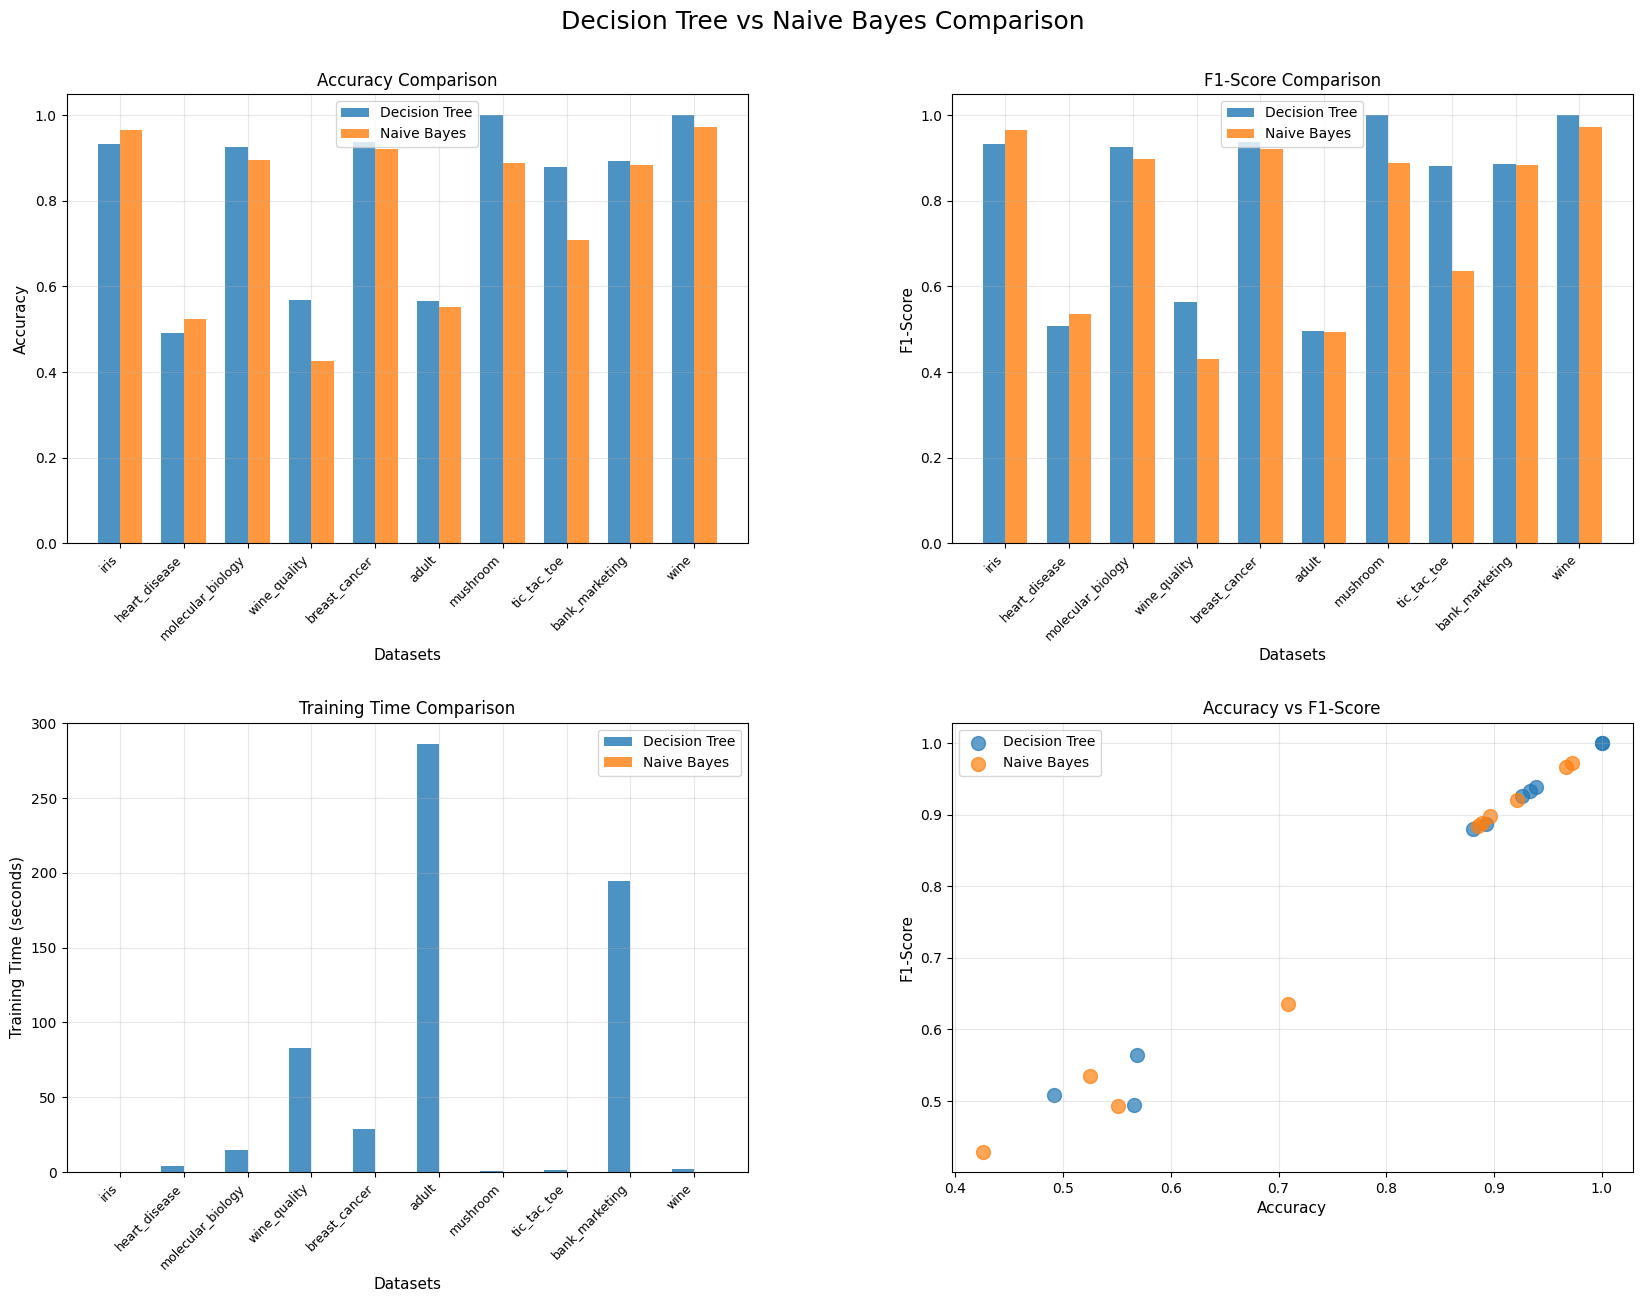

Detailed comparison plot saved to 'benchmarks/detailed_comparison.png'


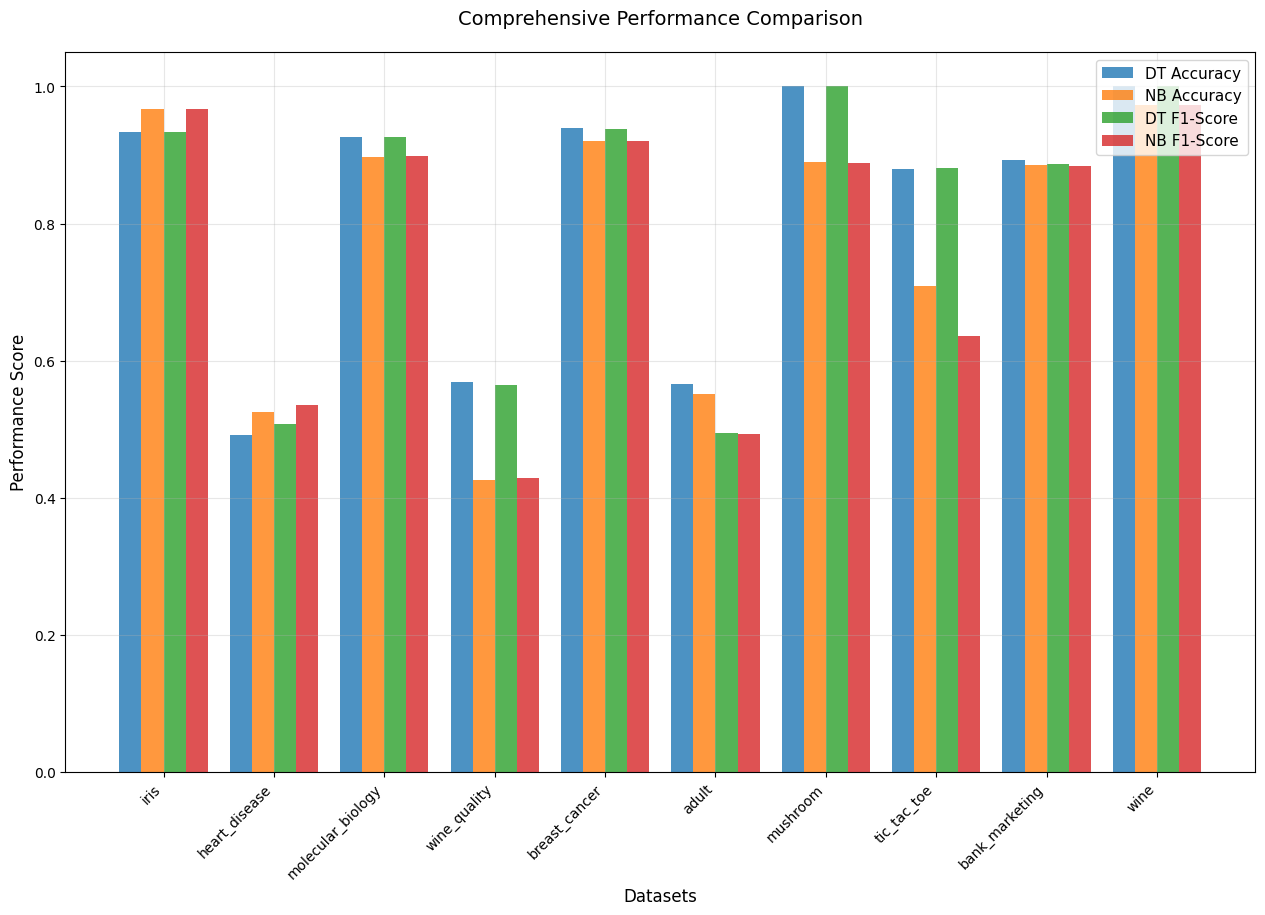

Metrics comparison plot saved to 'benchmarks/metrics_comparison.png'


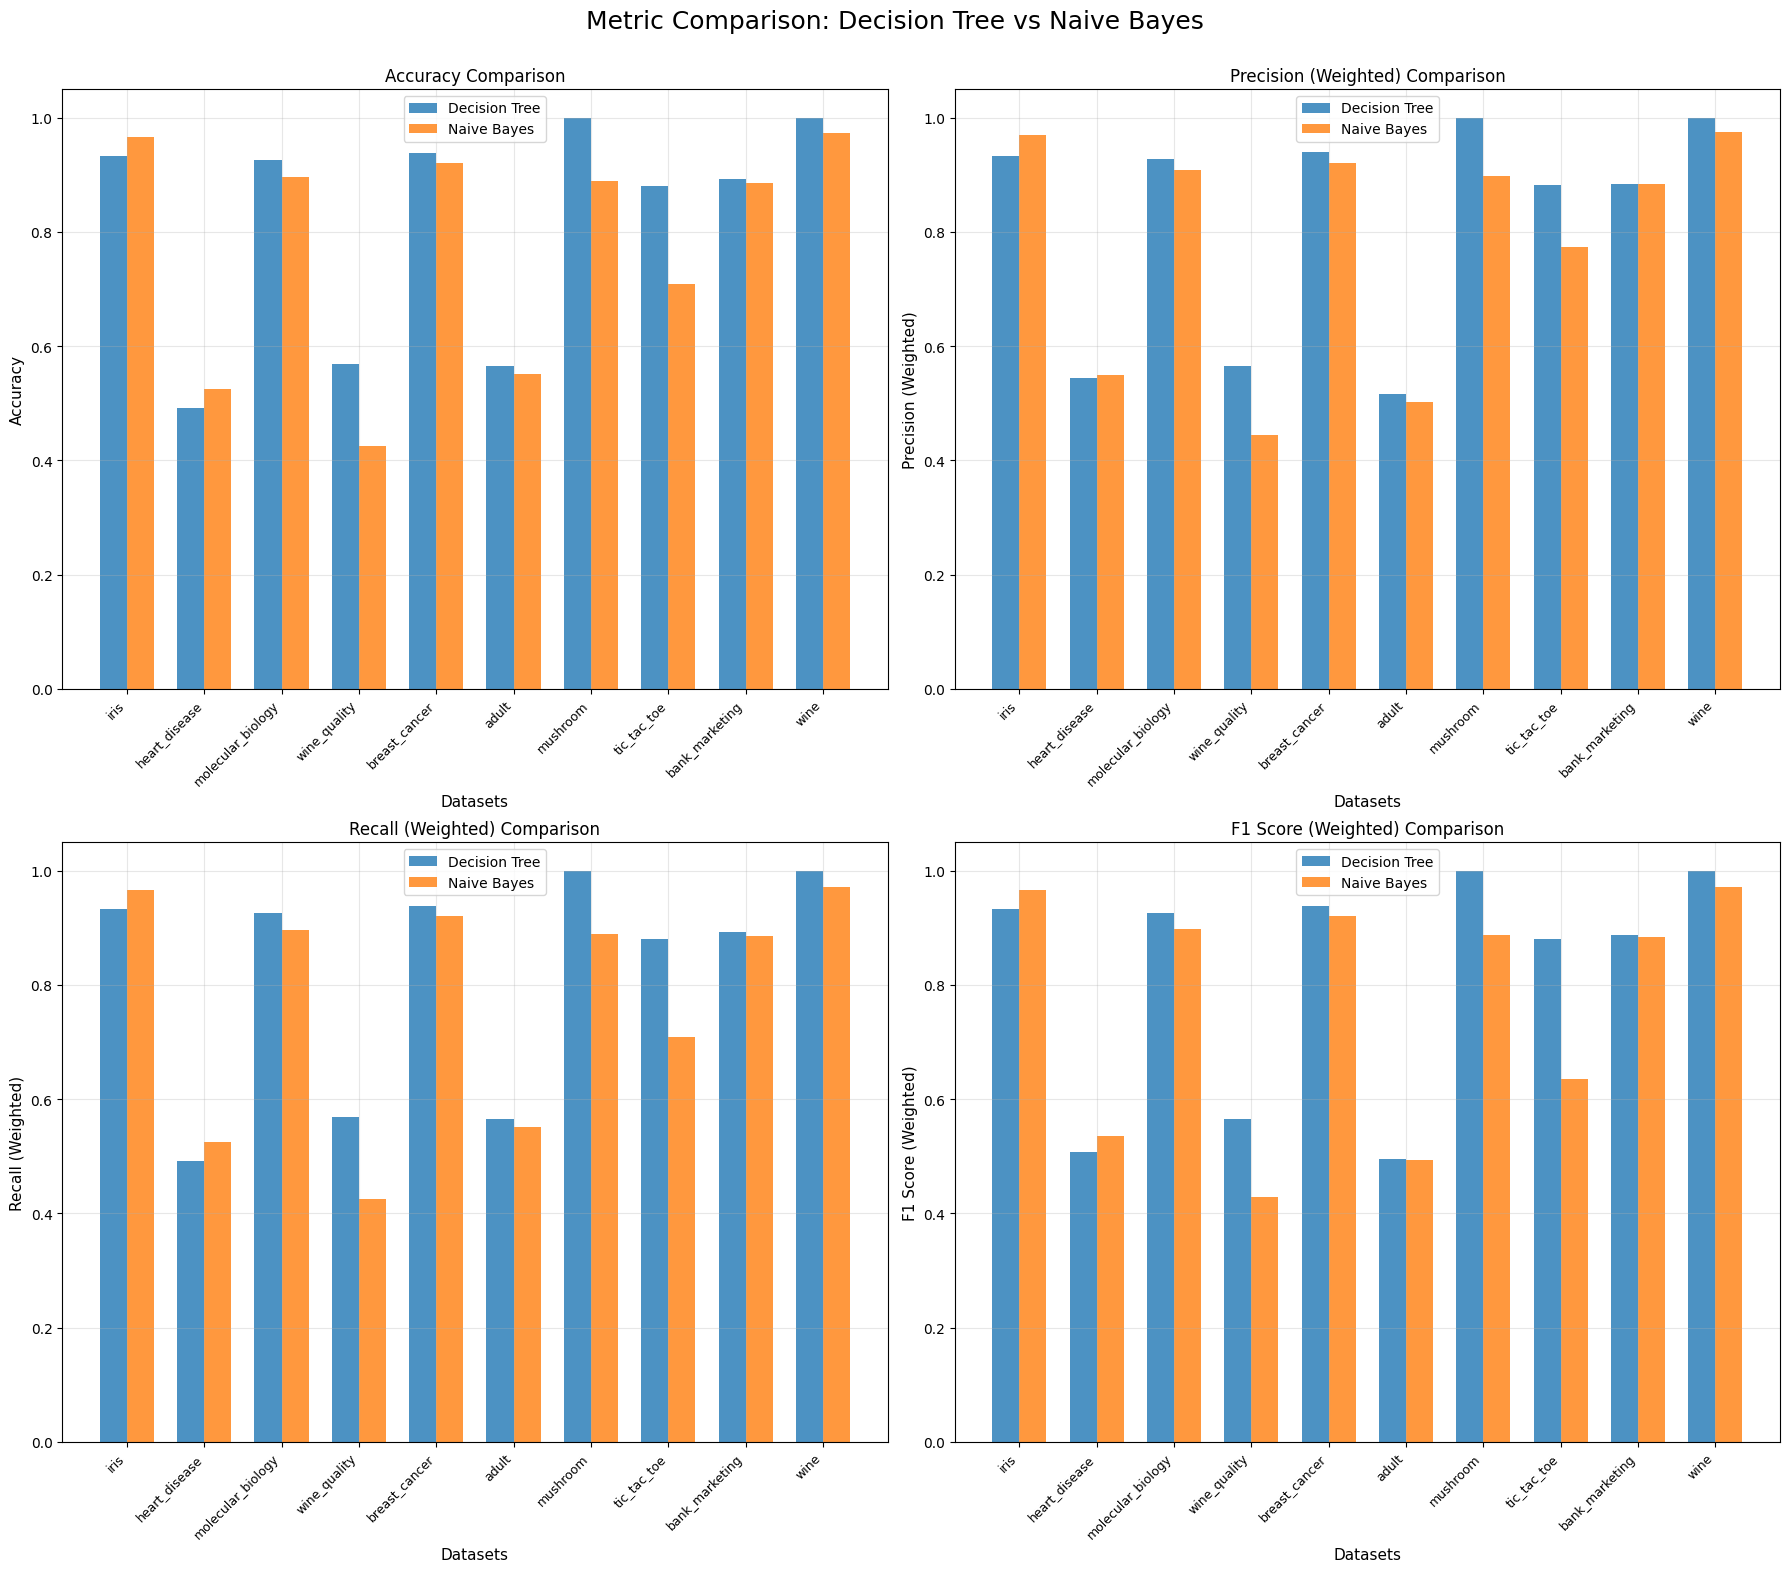

Class-specific metrics for iris saved to 'benchmarks/class_metrics_iris.png'


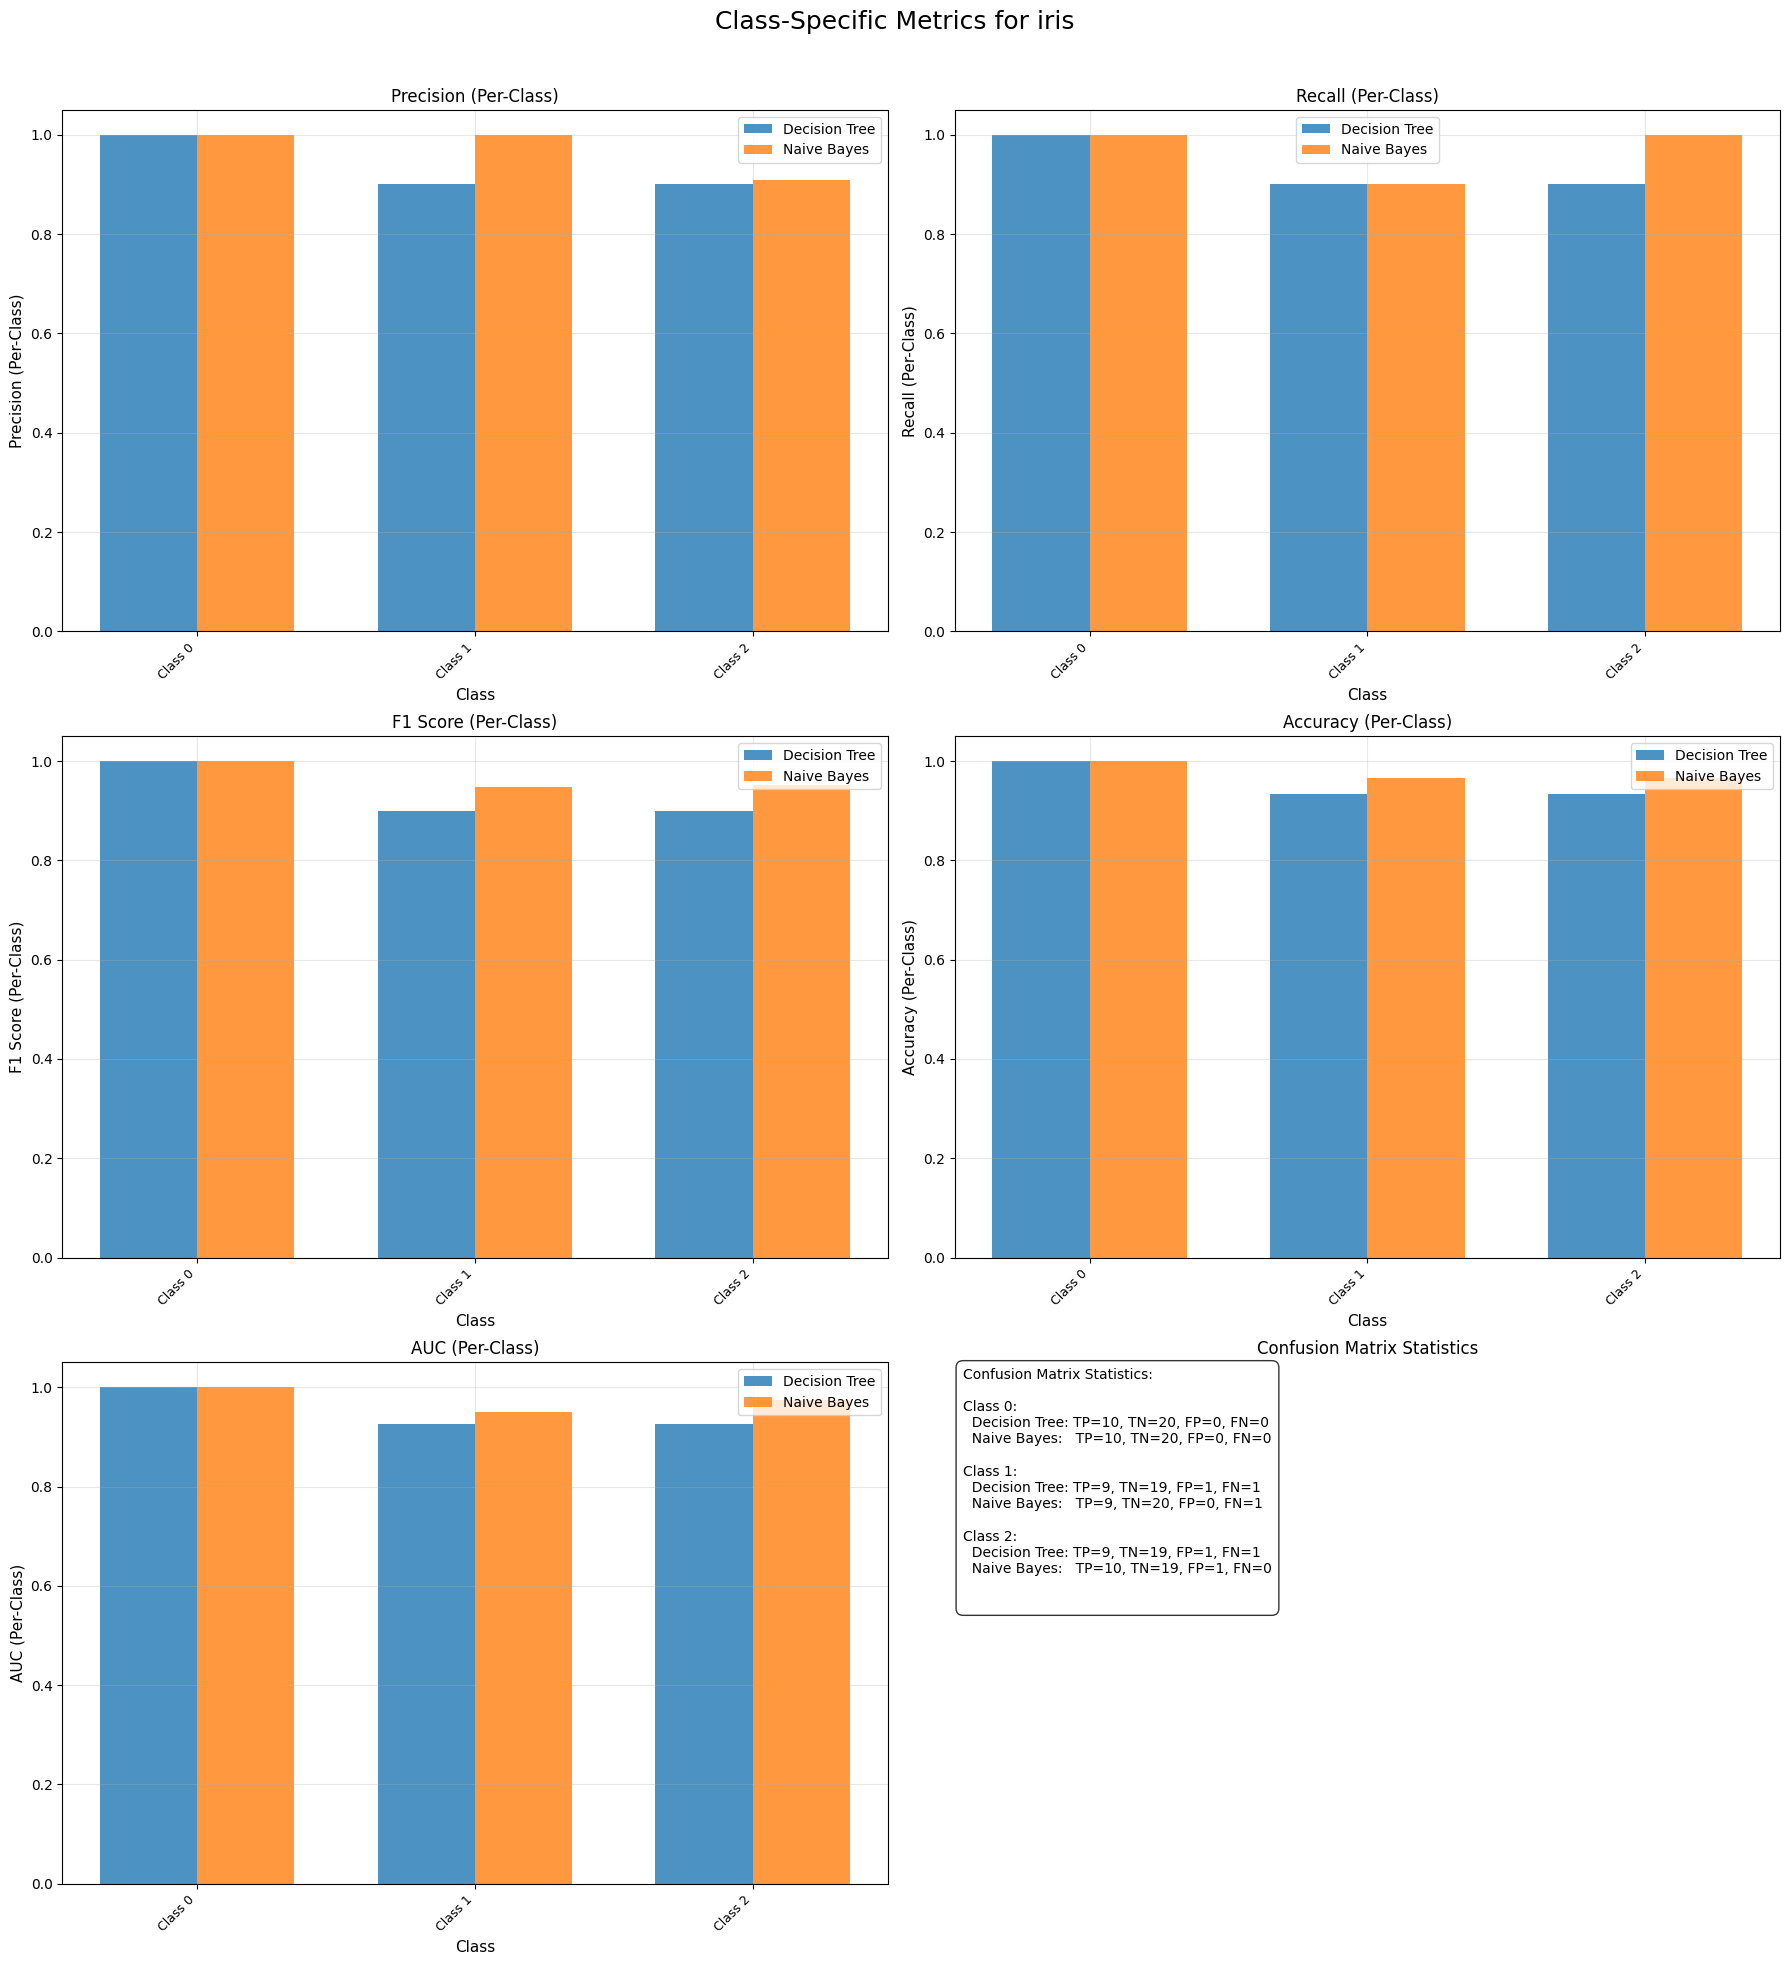

Class-specific metrics for heart_disease saved to 'benchmarks/class_metrics_heart_disease.png'


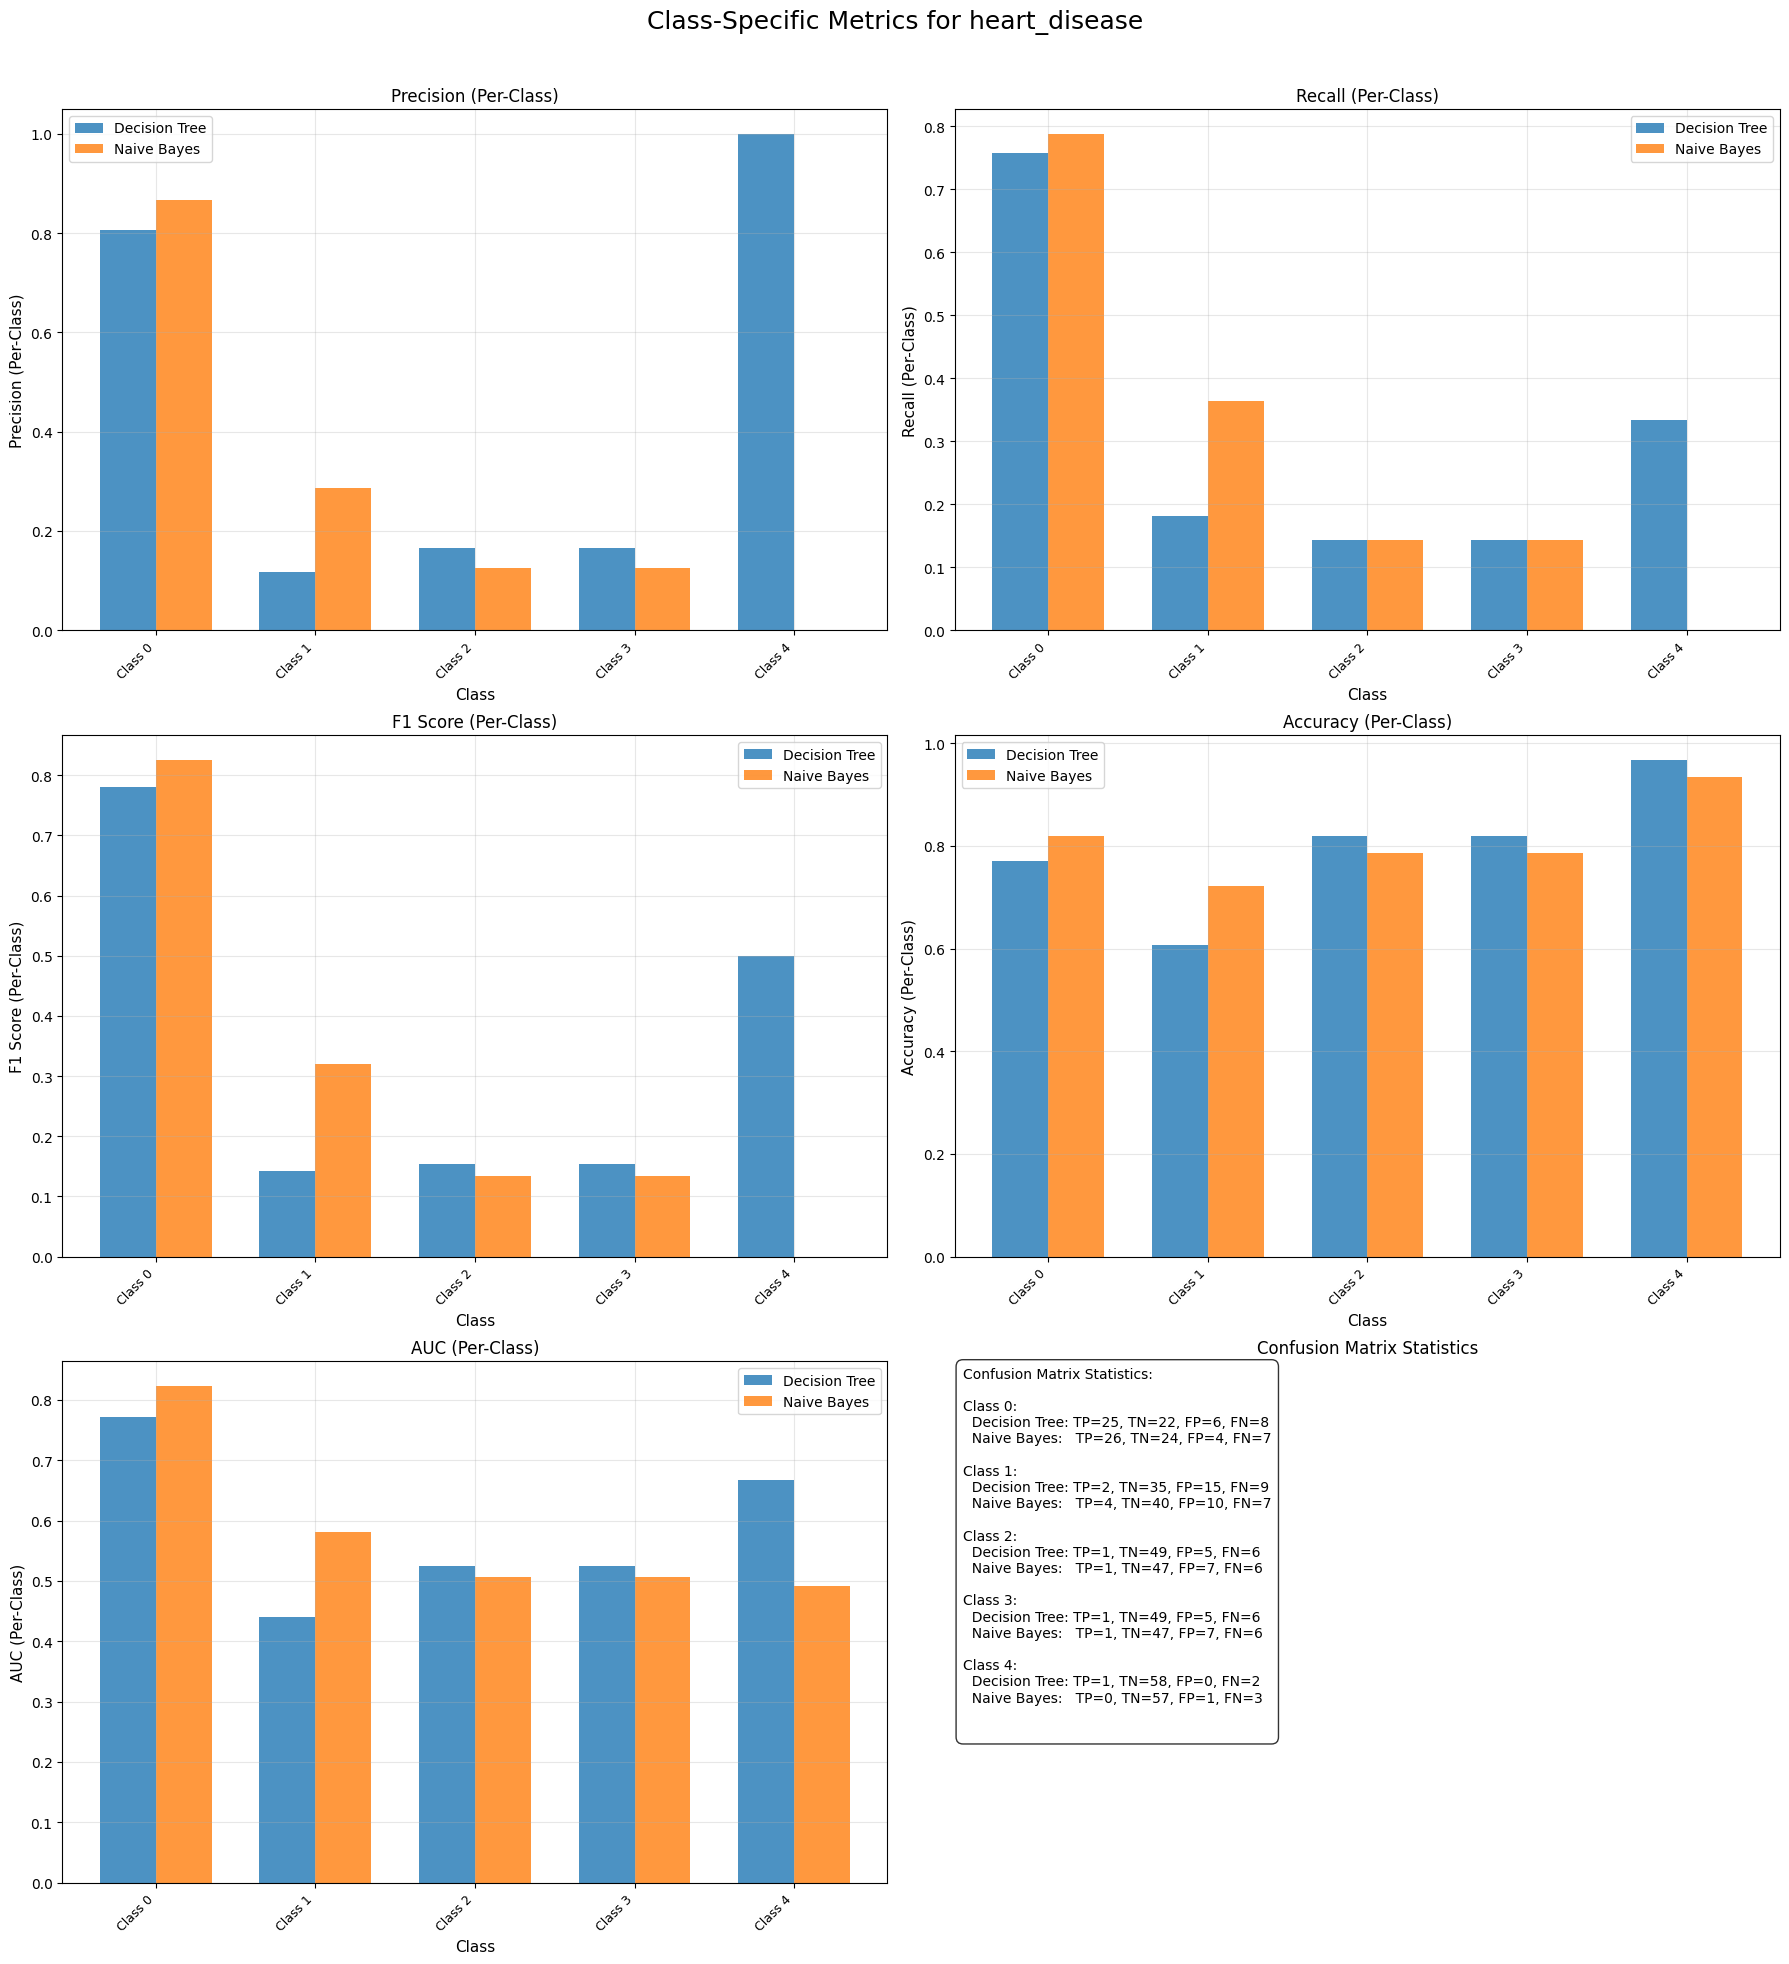

Class-specific metrics for molecular_biology saved to 'benchmarks/class_metrics_molecular_biology.png'


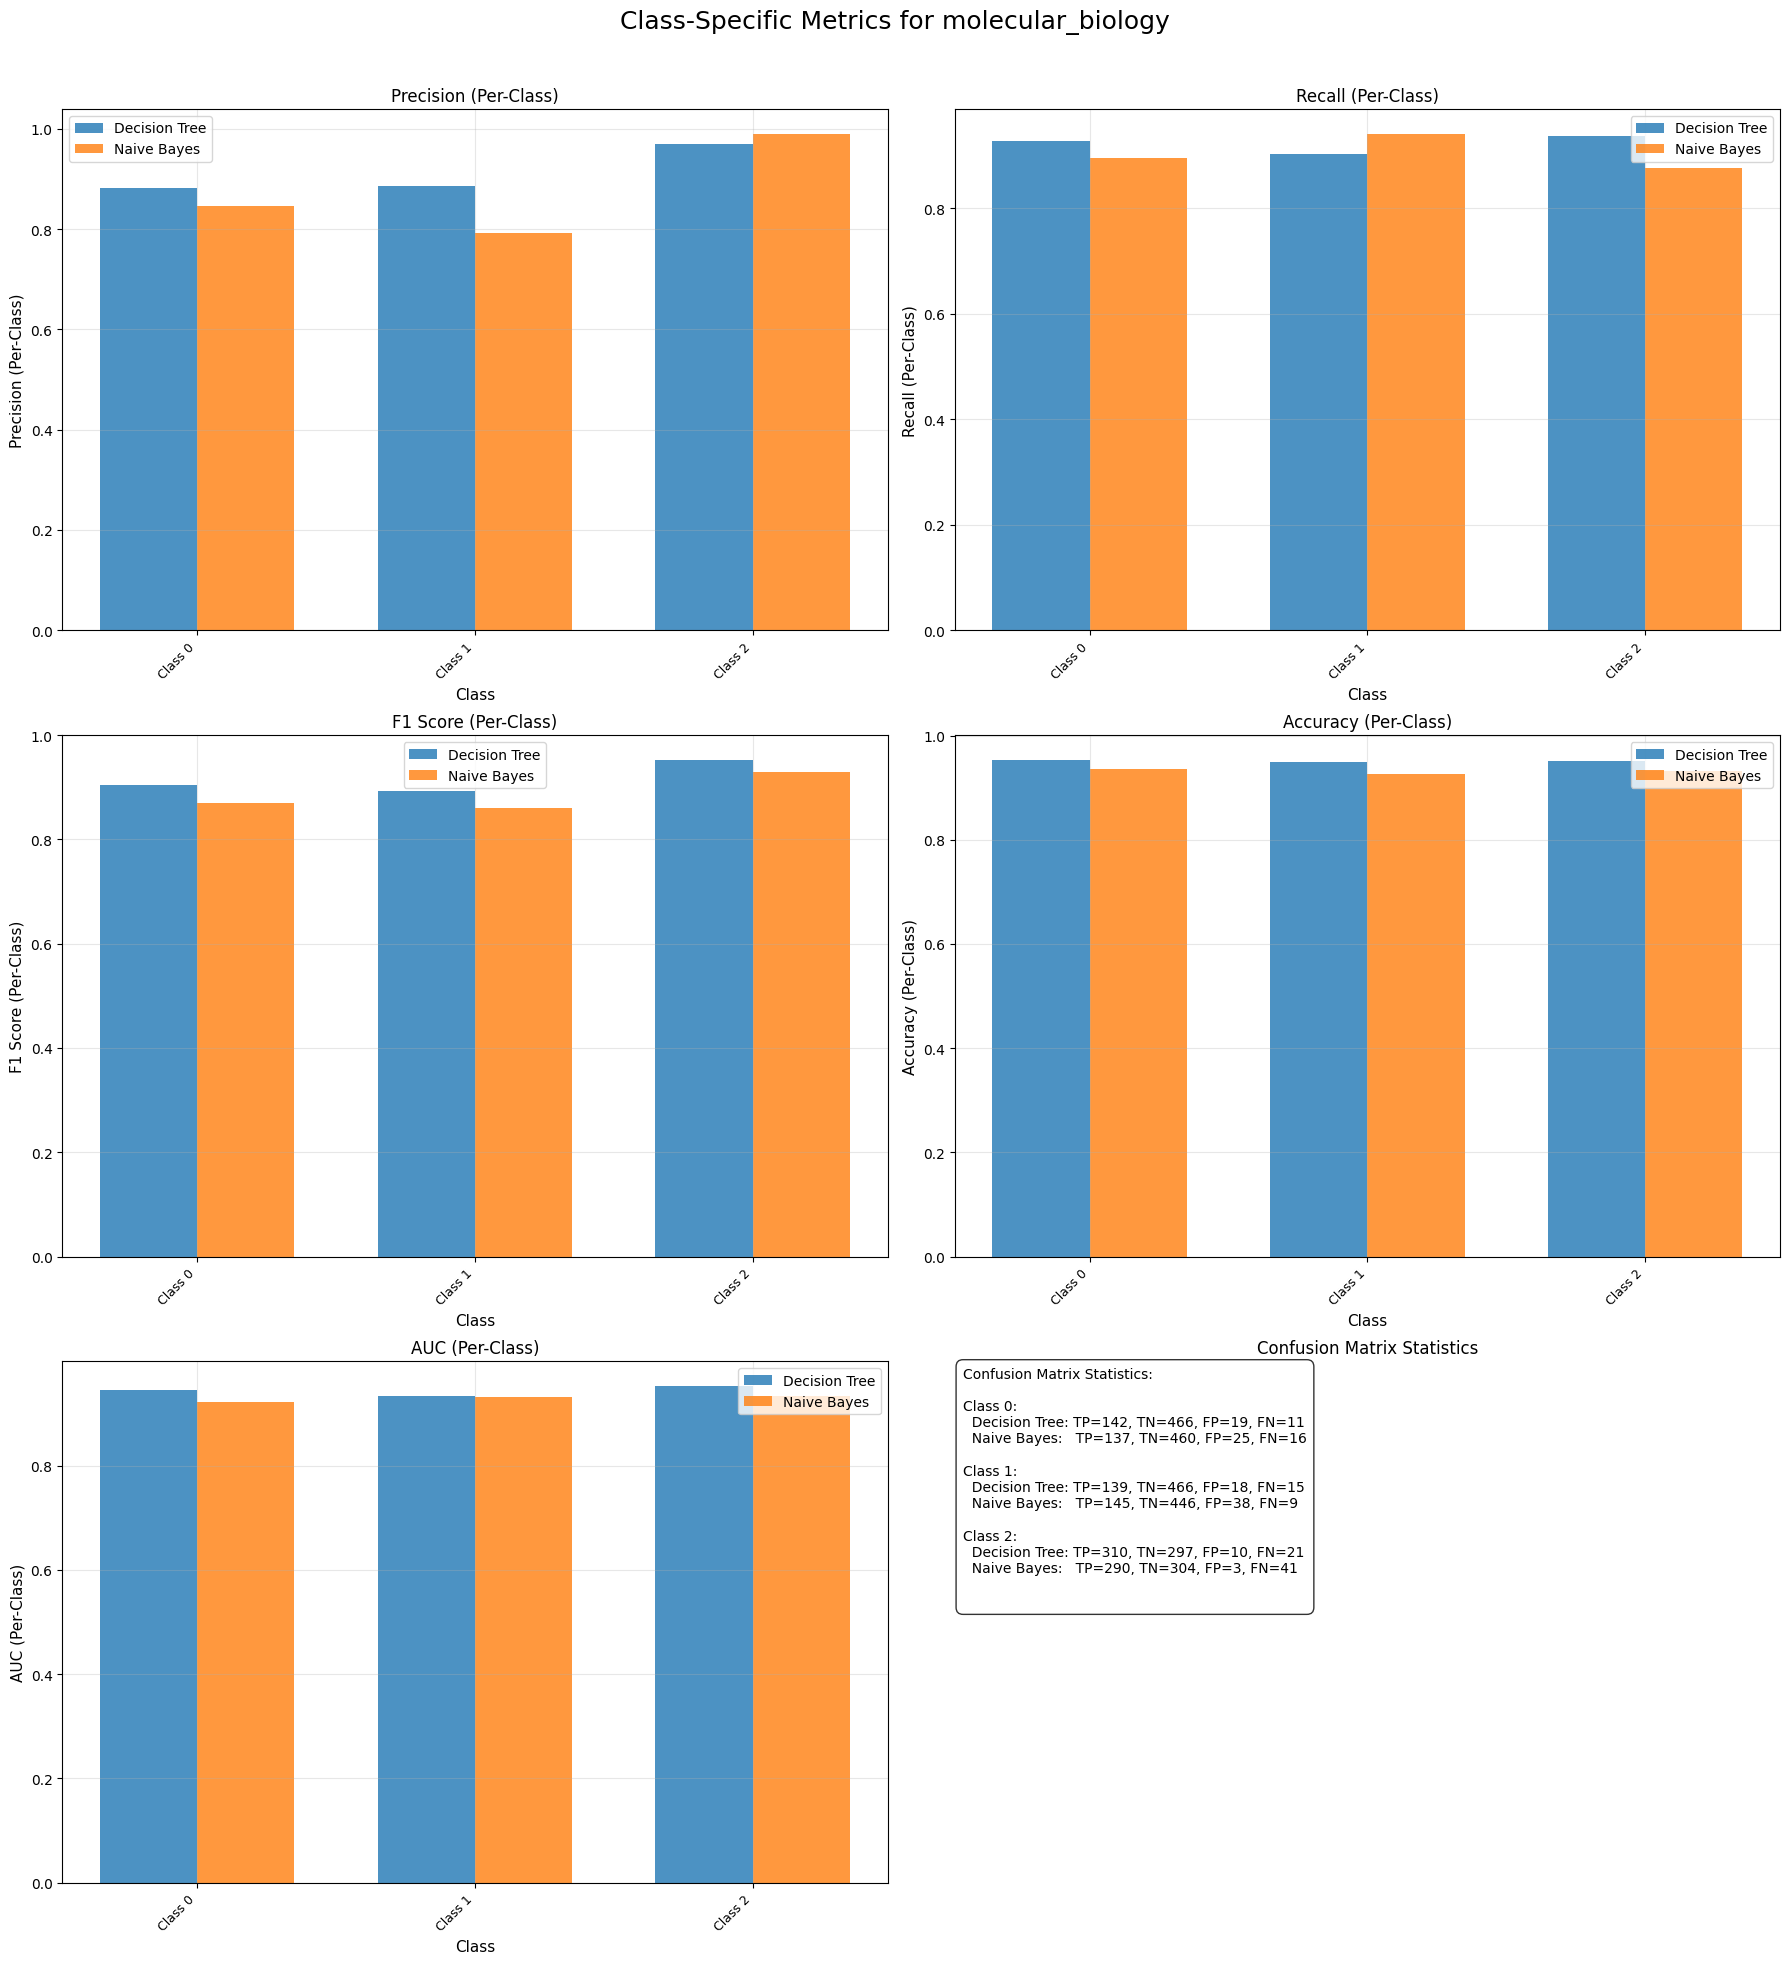

Class-specific metrics for wine_quality saved to 'benchmarks/class_metrics_wine_quality.png'


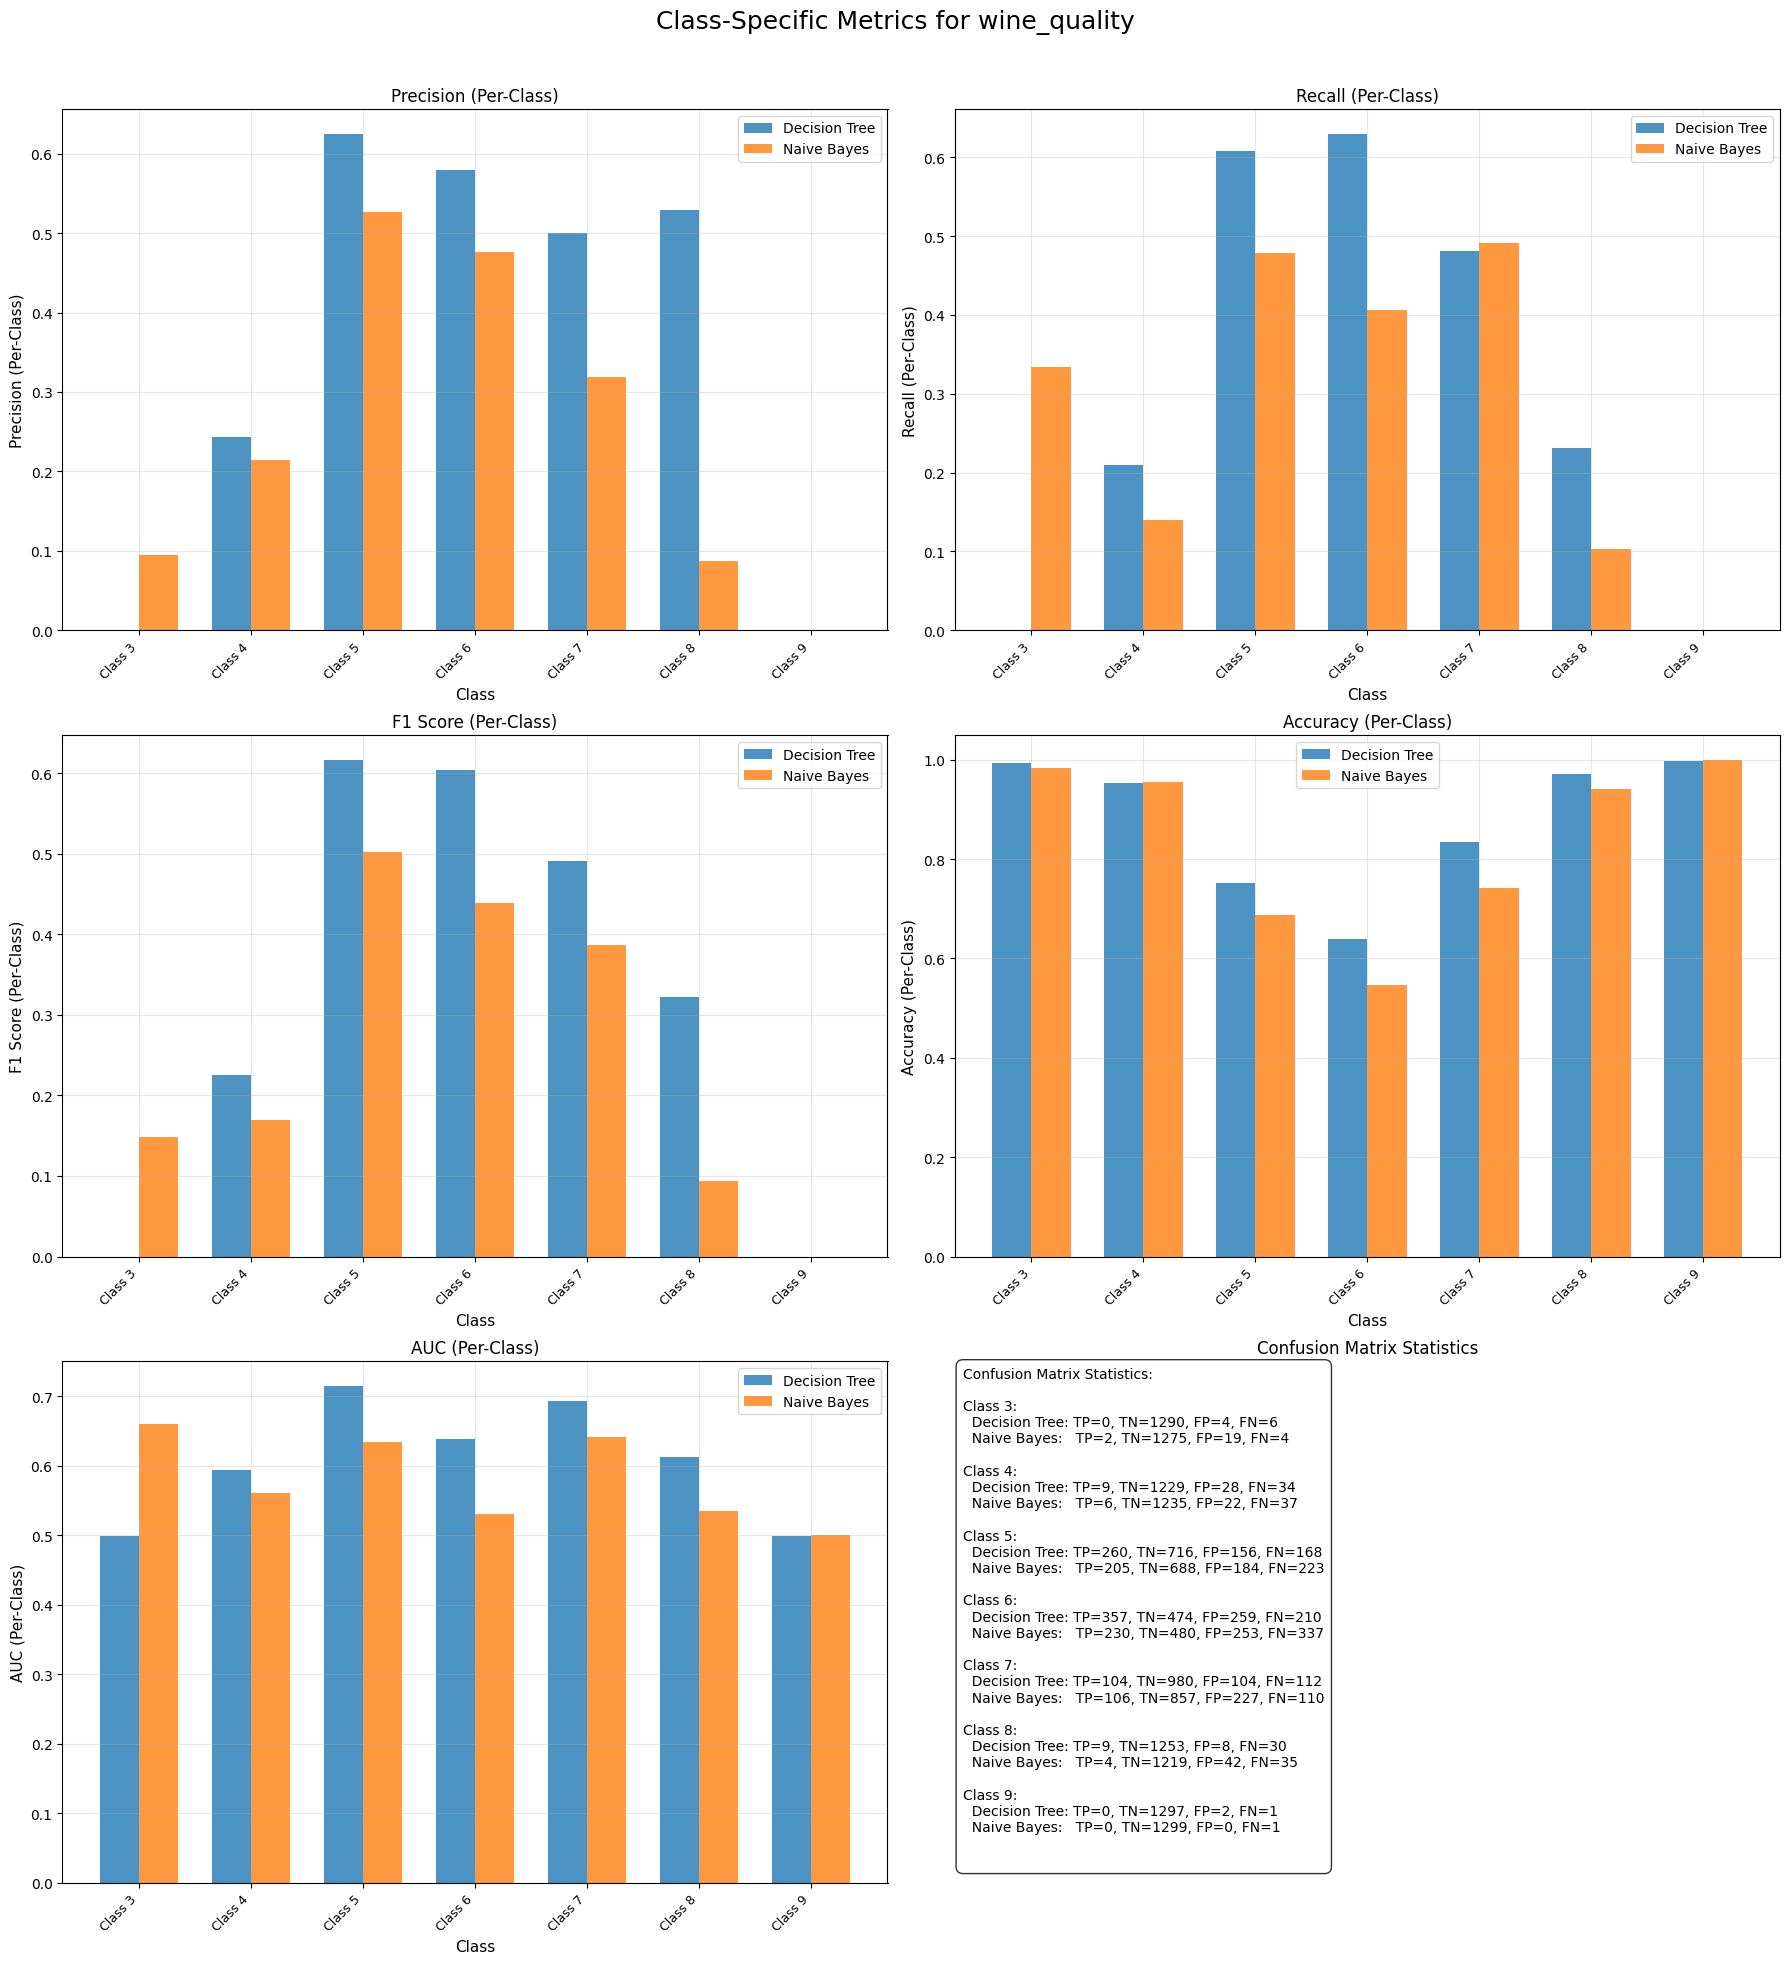

Class-specific metrics for breast_cancer saved to 'benchmarks/class_metrics_breast_cancer.png'


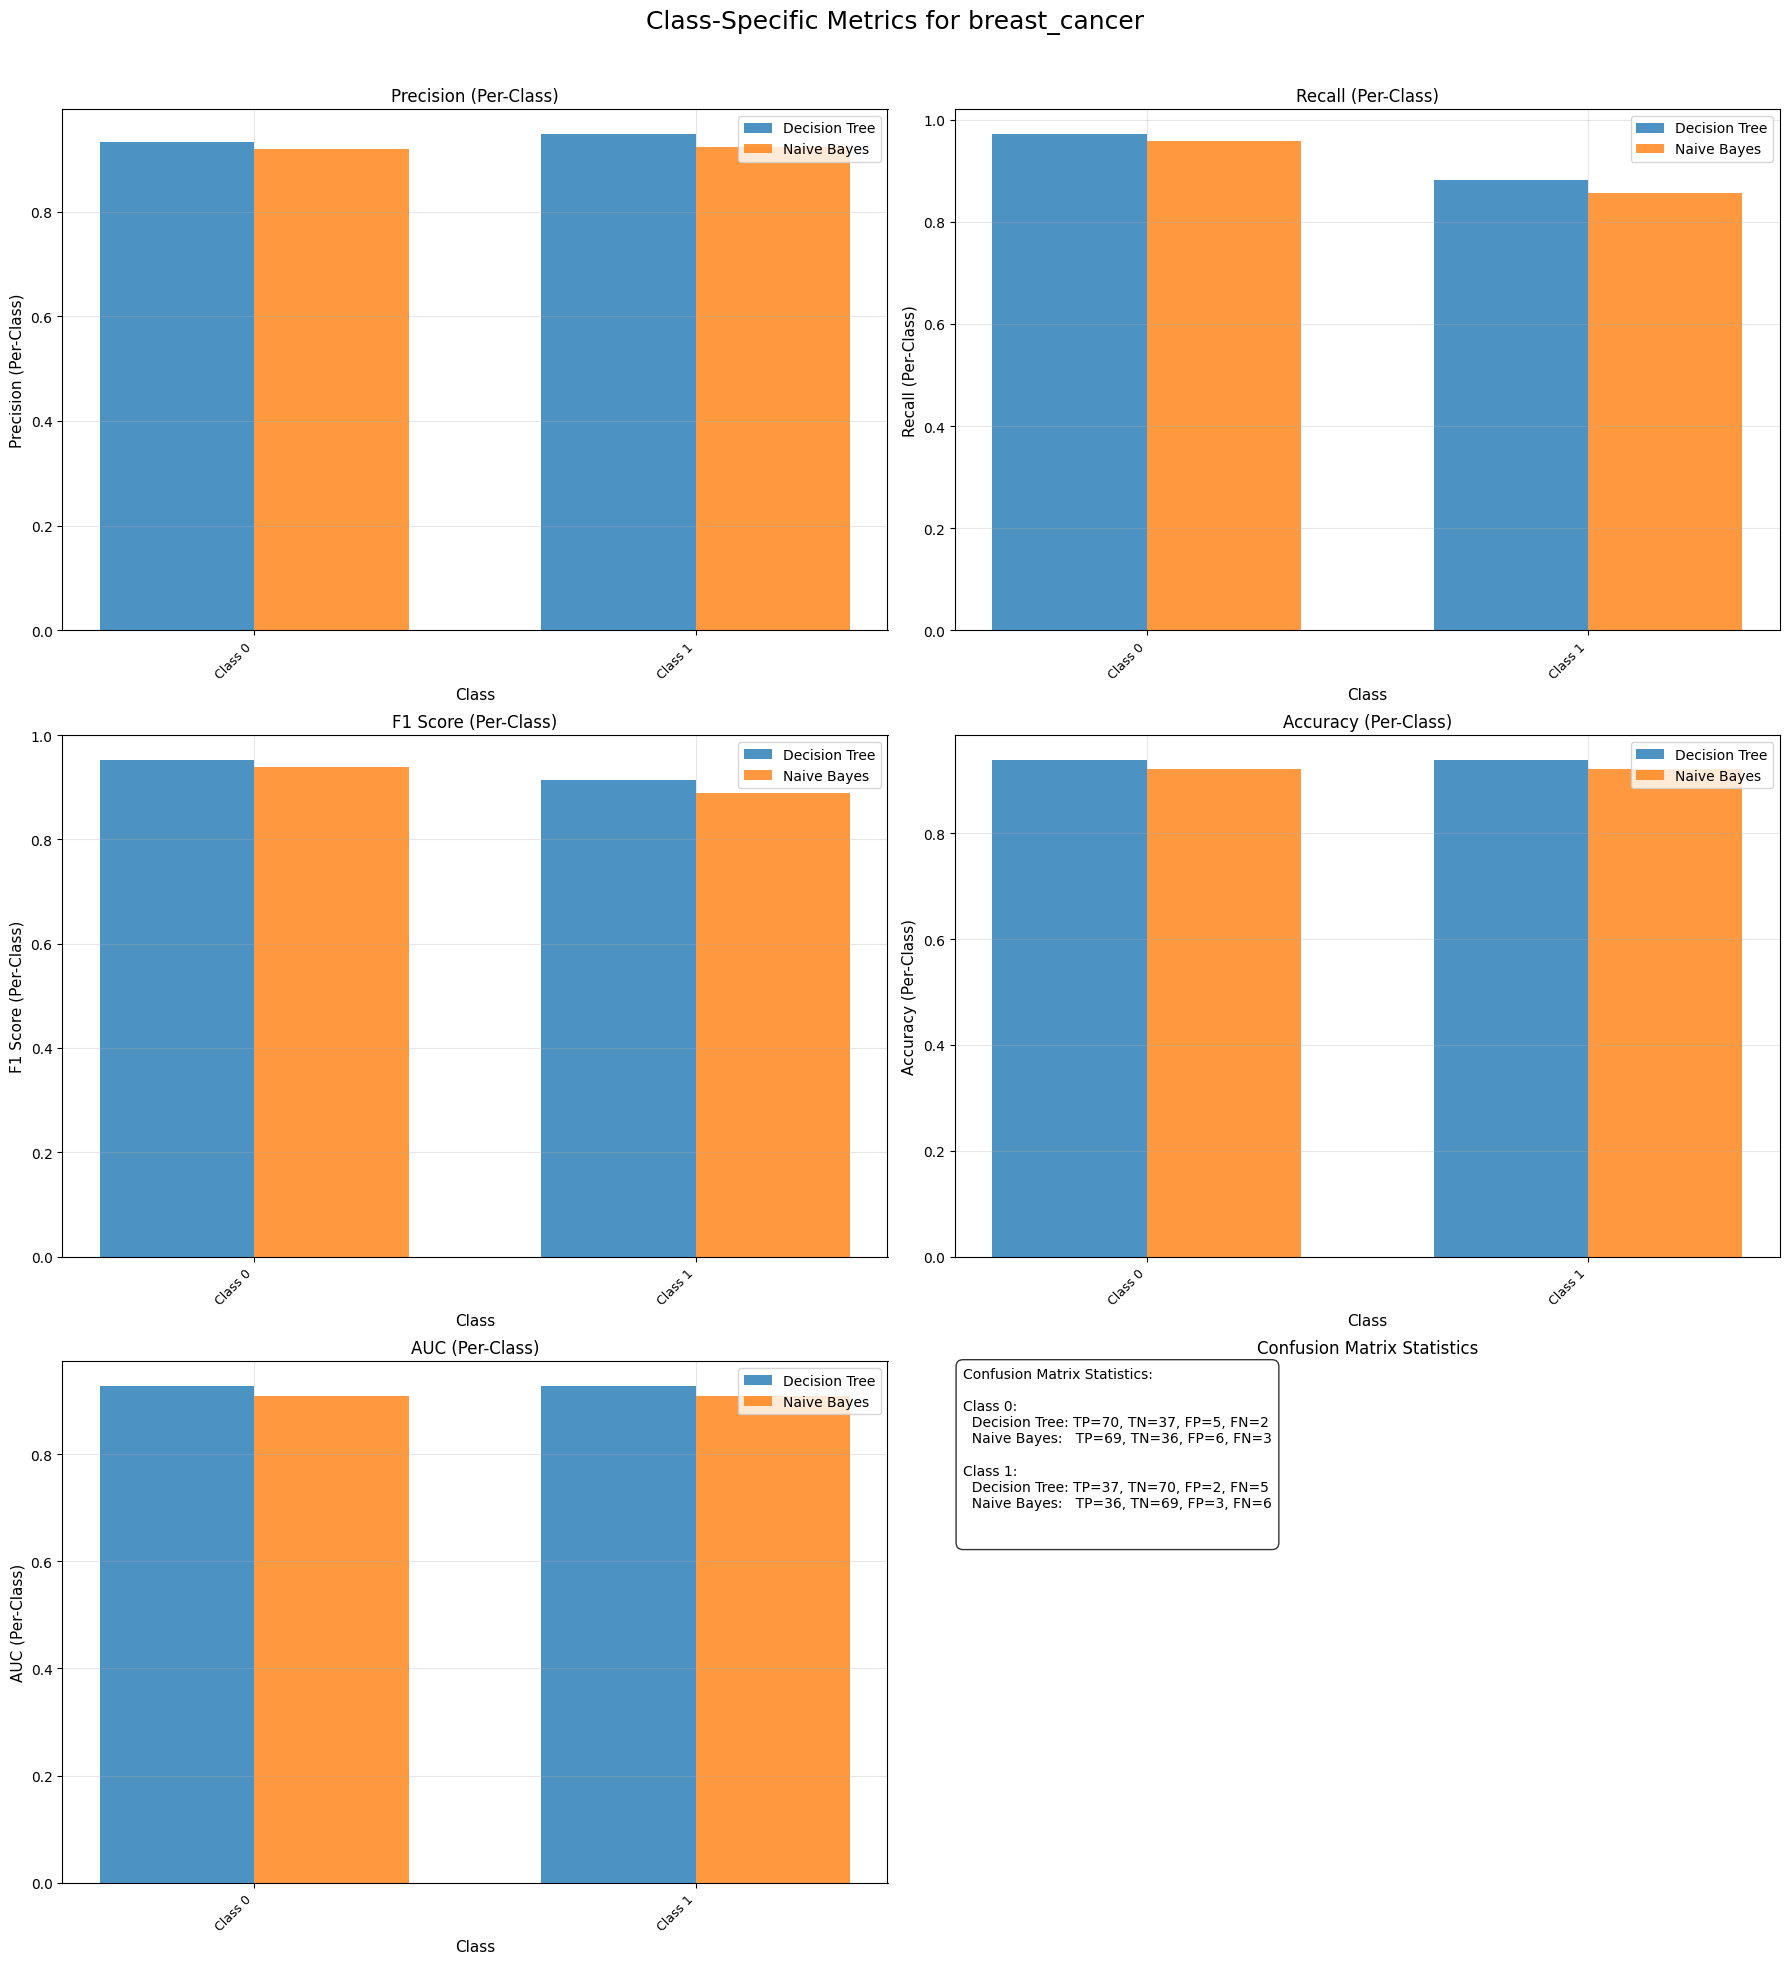

Class-specific metrics for adult saved to 'benchmarks/class_metrics_adult.png'


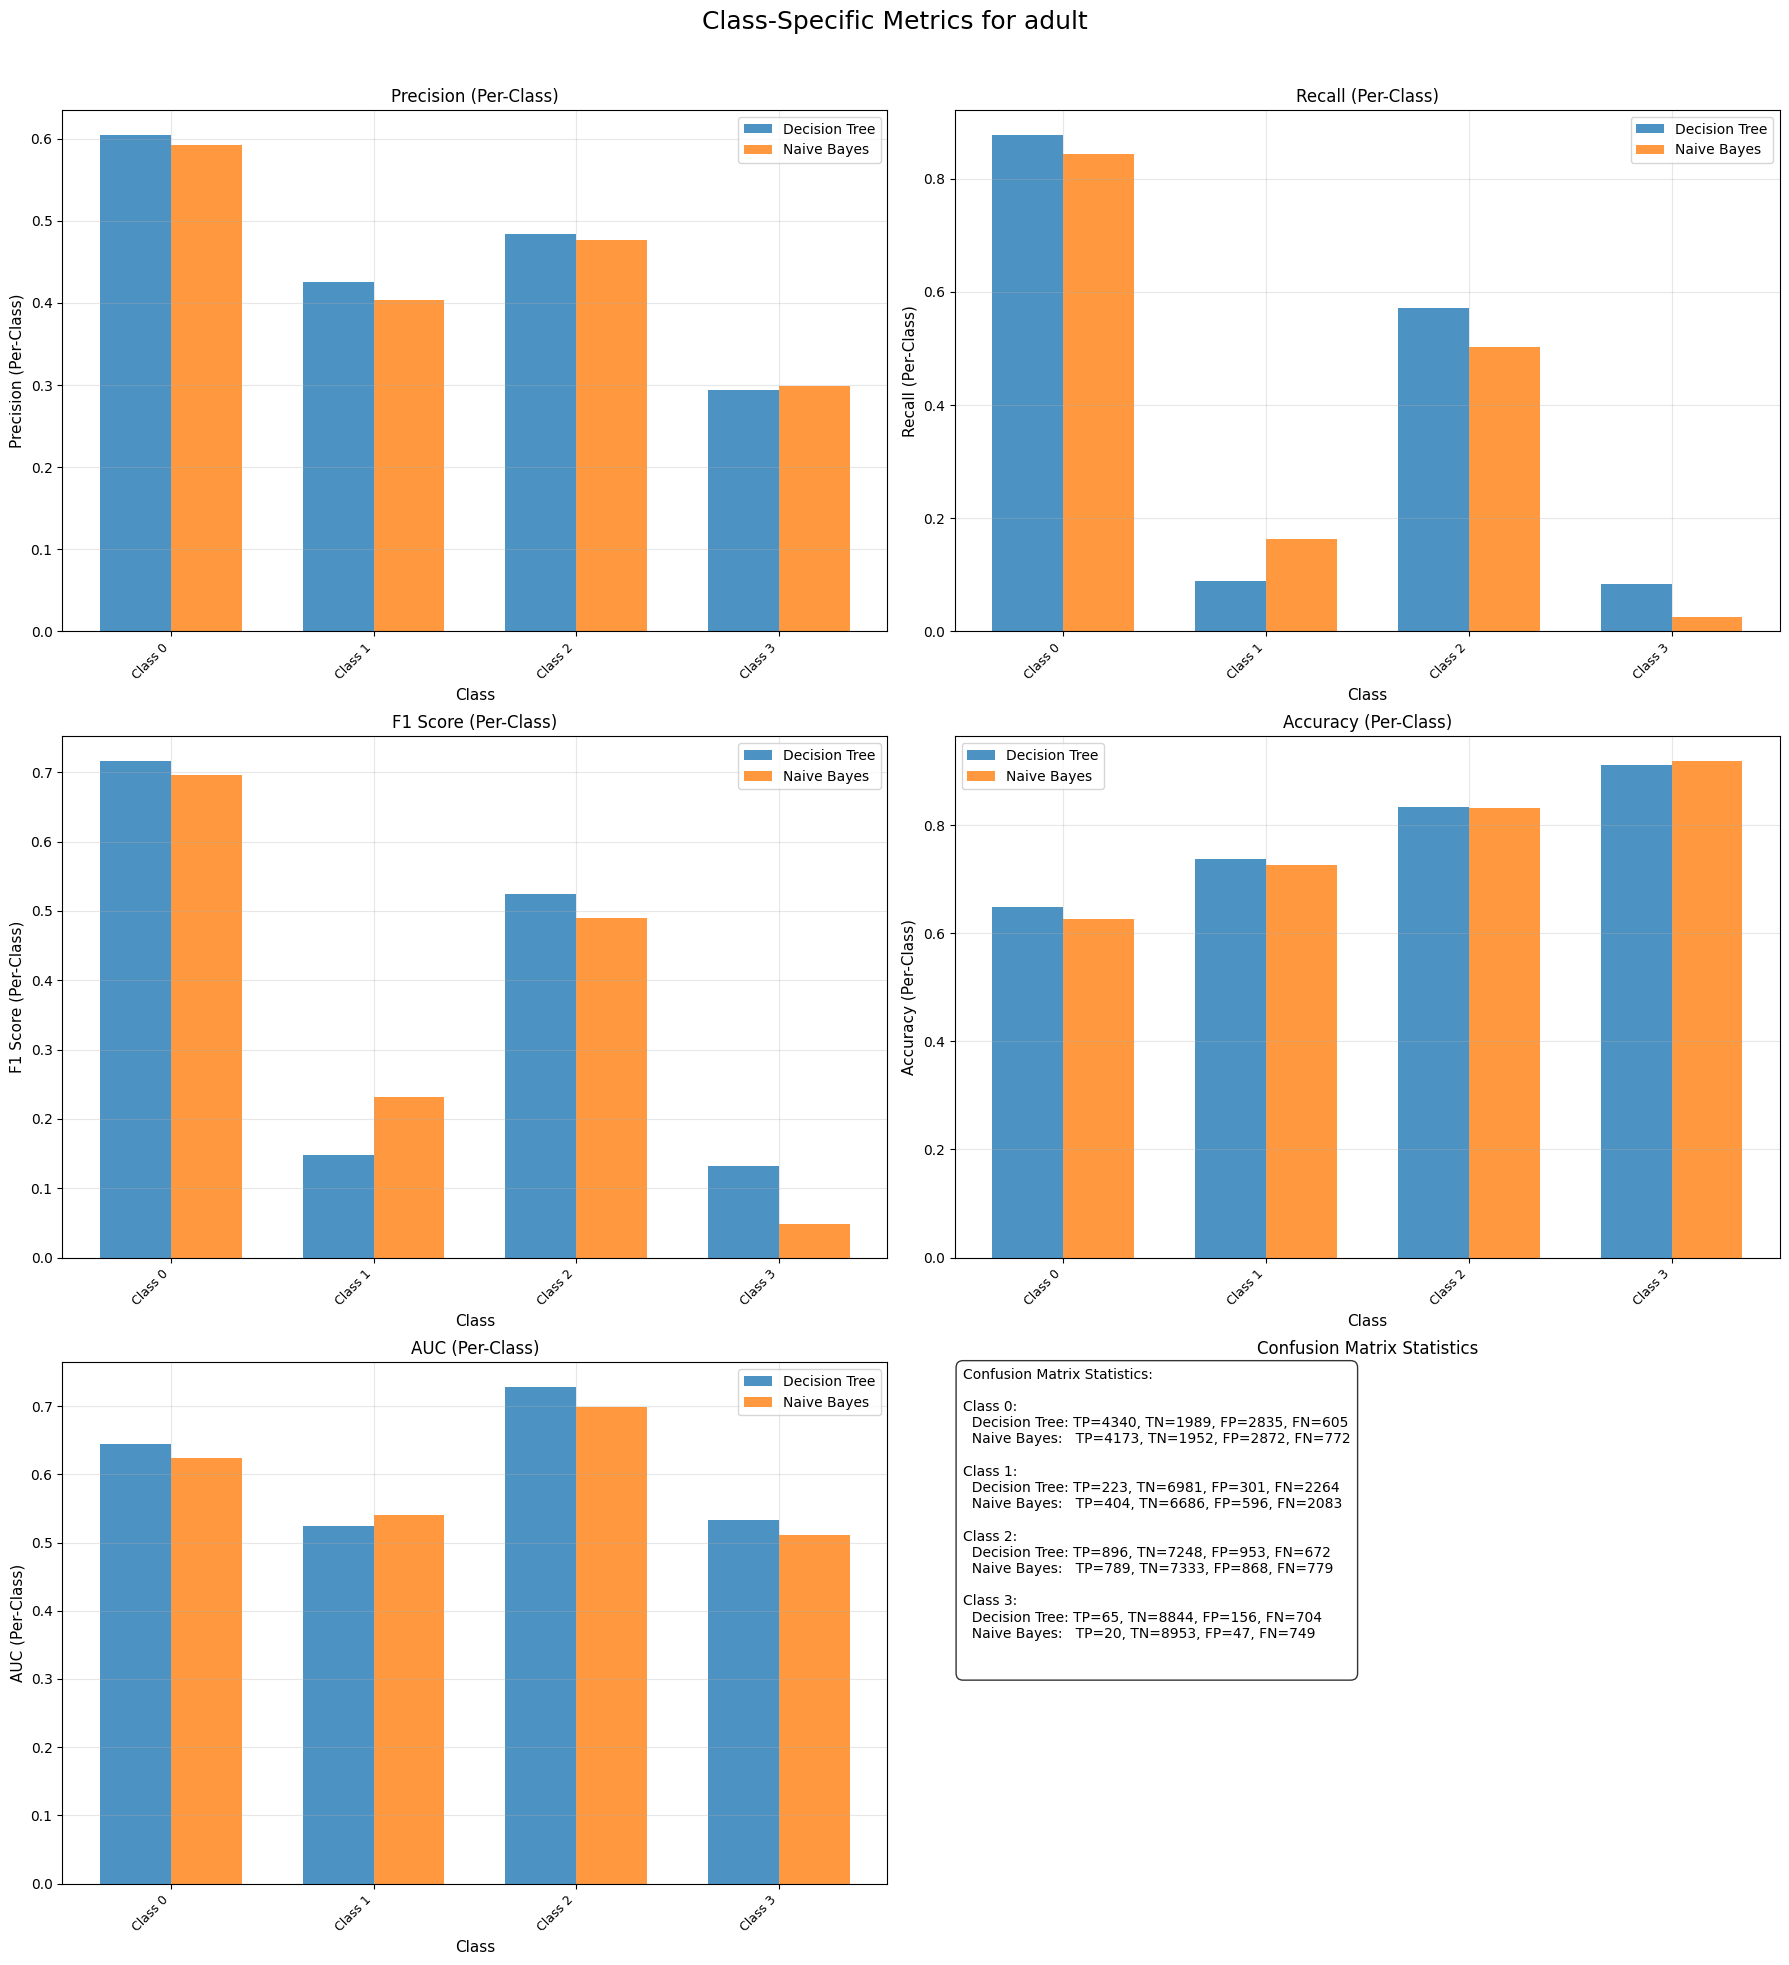

Class-specific metrics for mushroom saved to 'benchmarks/class_metrics_mushroom.png'


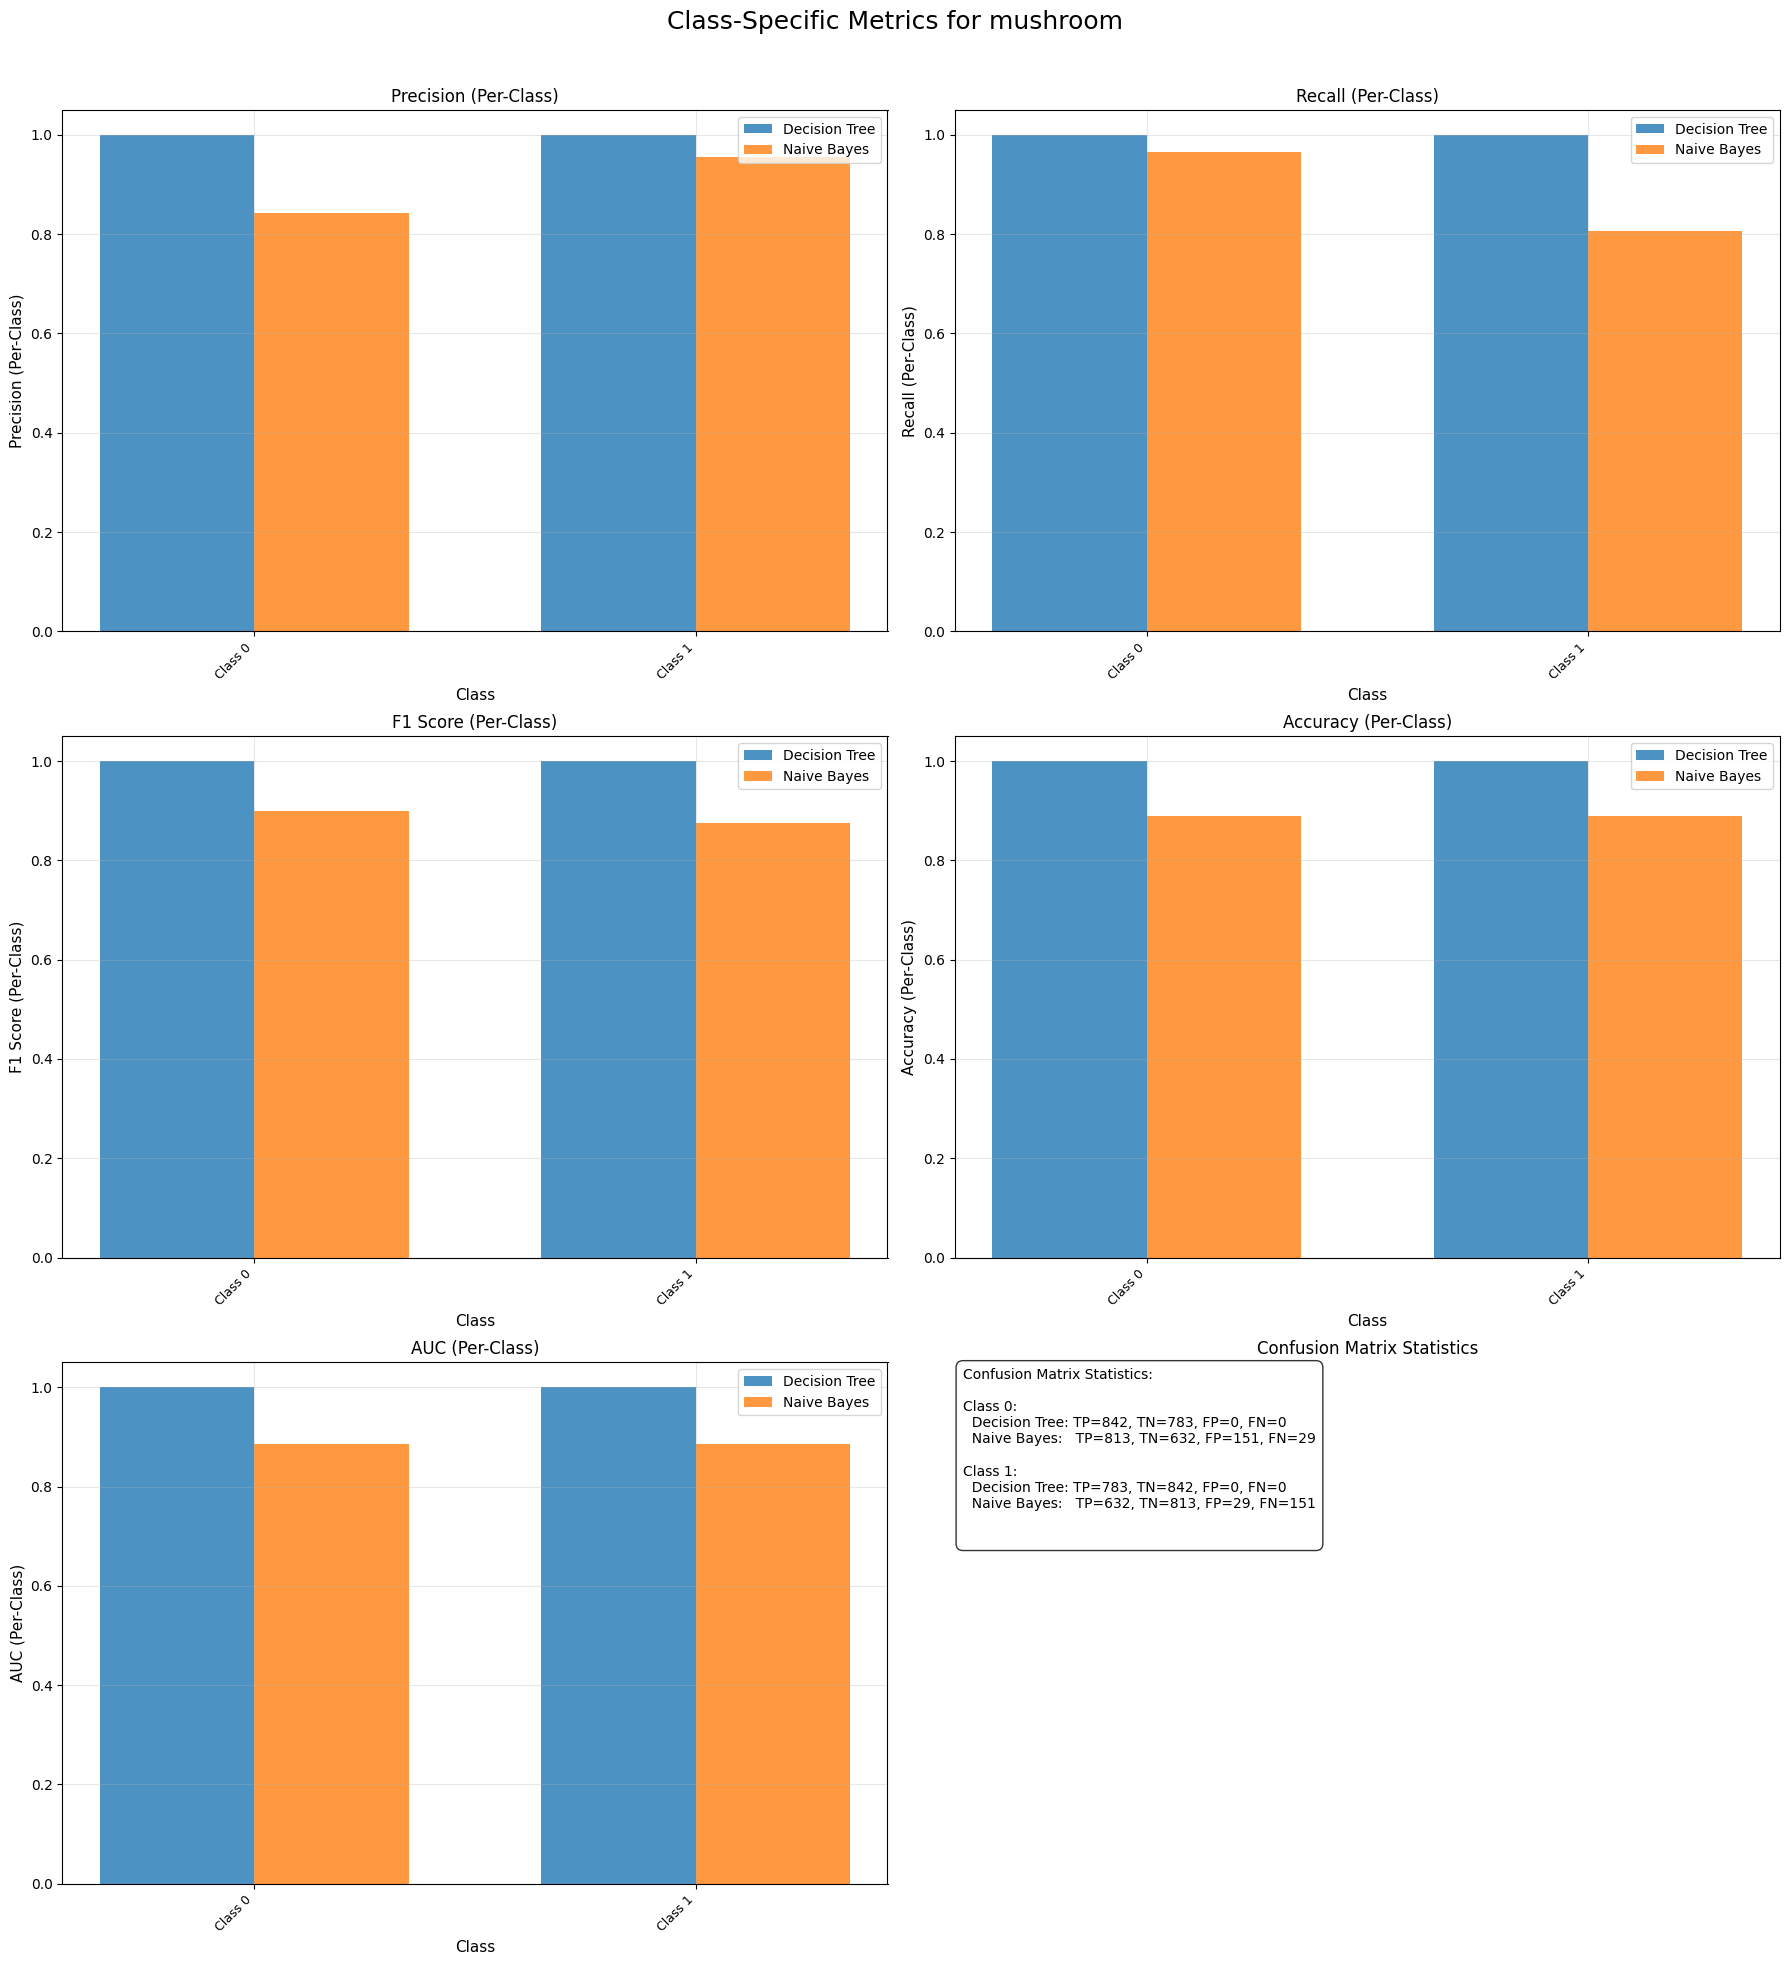

Class-specific metrics for tic_tac_toe saved to 'benchmarks/class_metrics_tic_tac_toe.png'


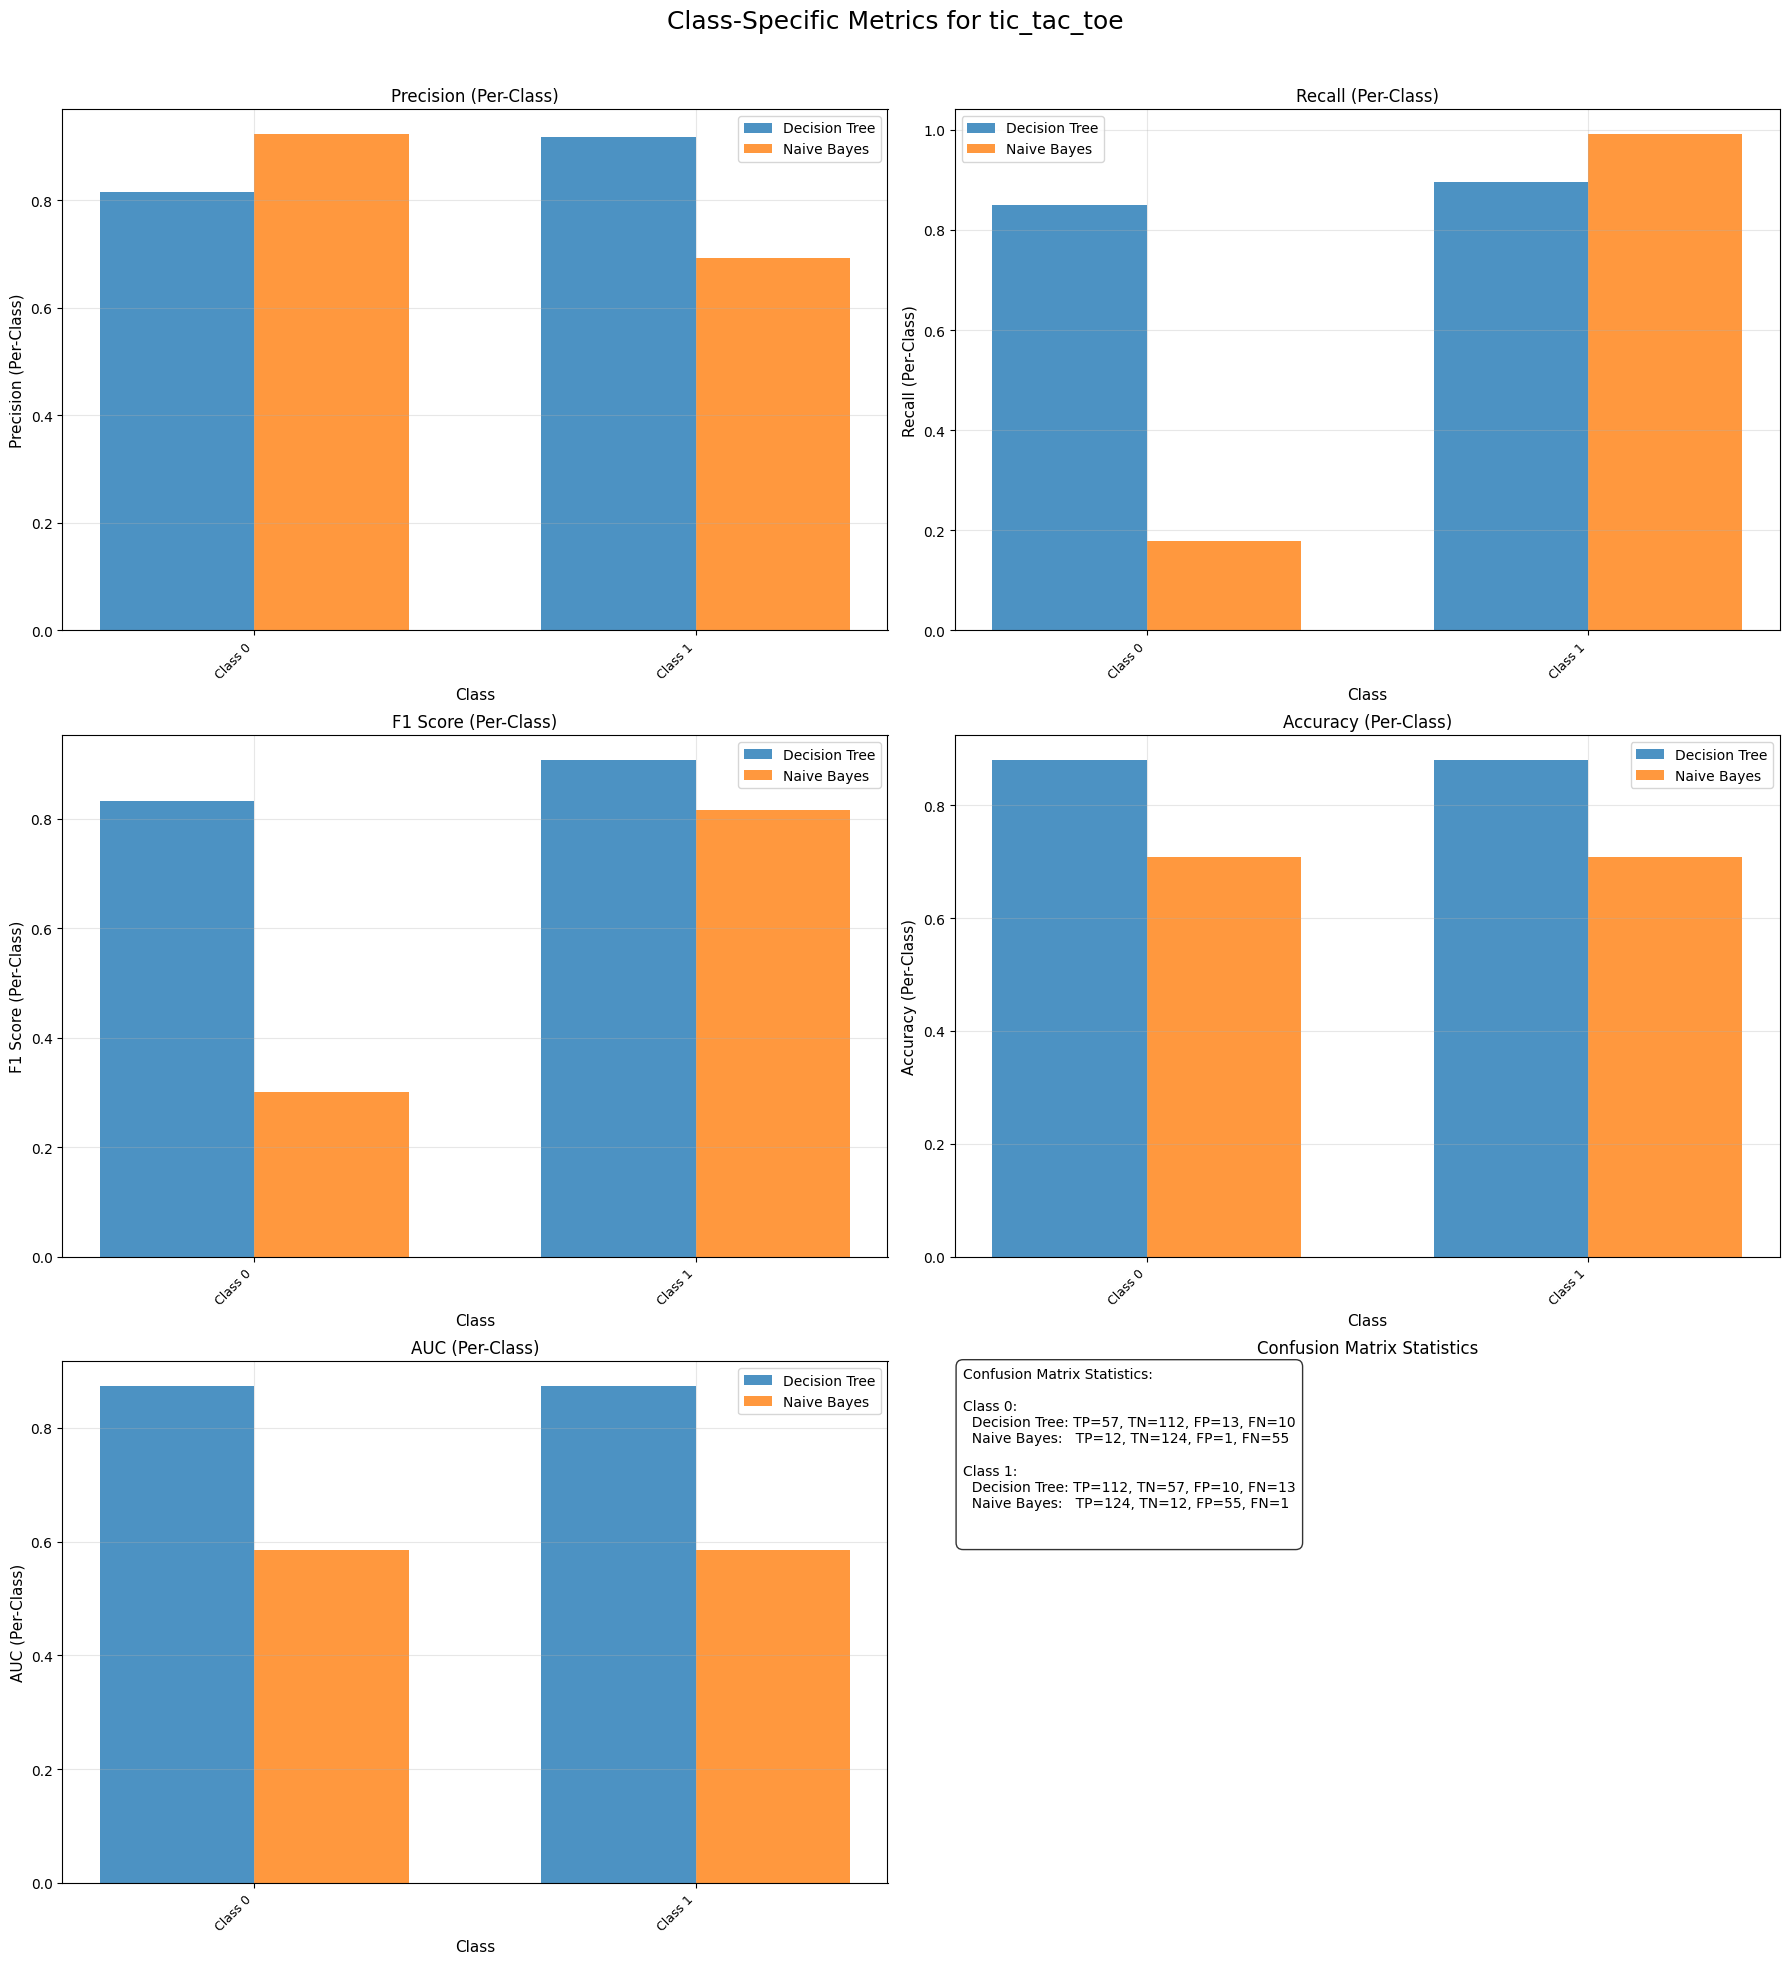

Class-specific metrics for bank_marketing saved to 'benchmarks/class_metrics_bank_marketing.png'


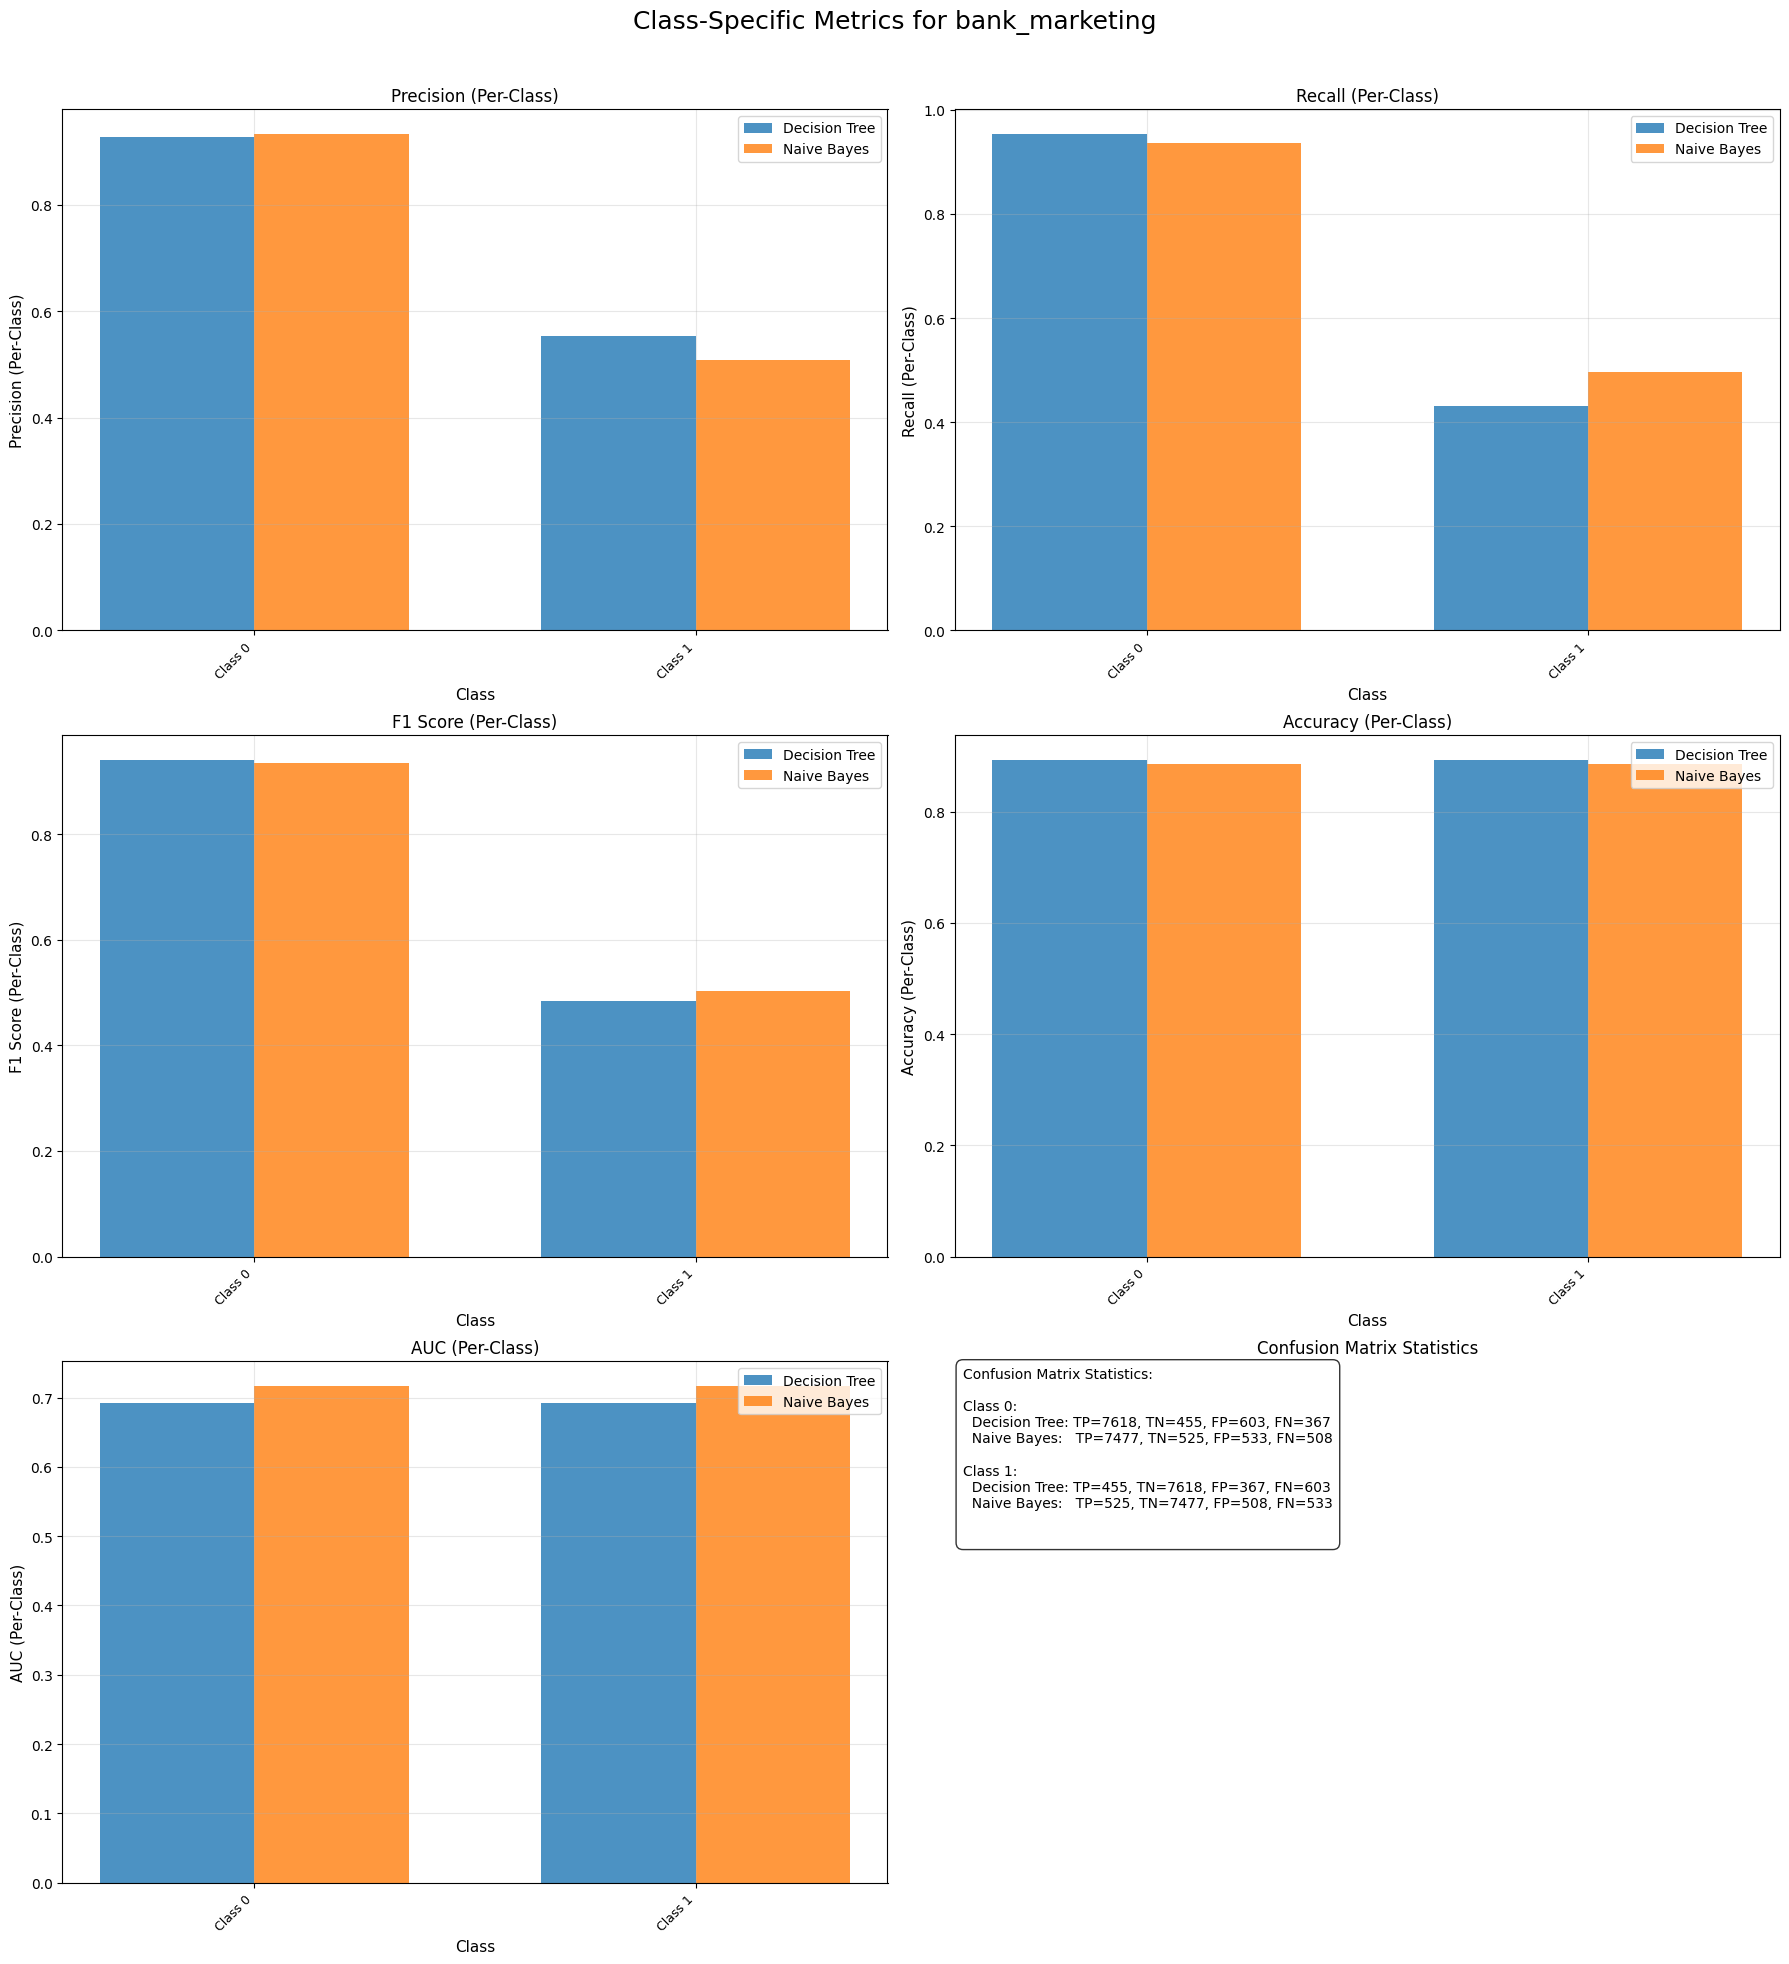

Class-specific metrics for wine saved to 'benchmarks/class_metrics_wine.png'


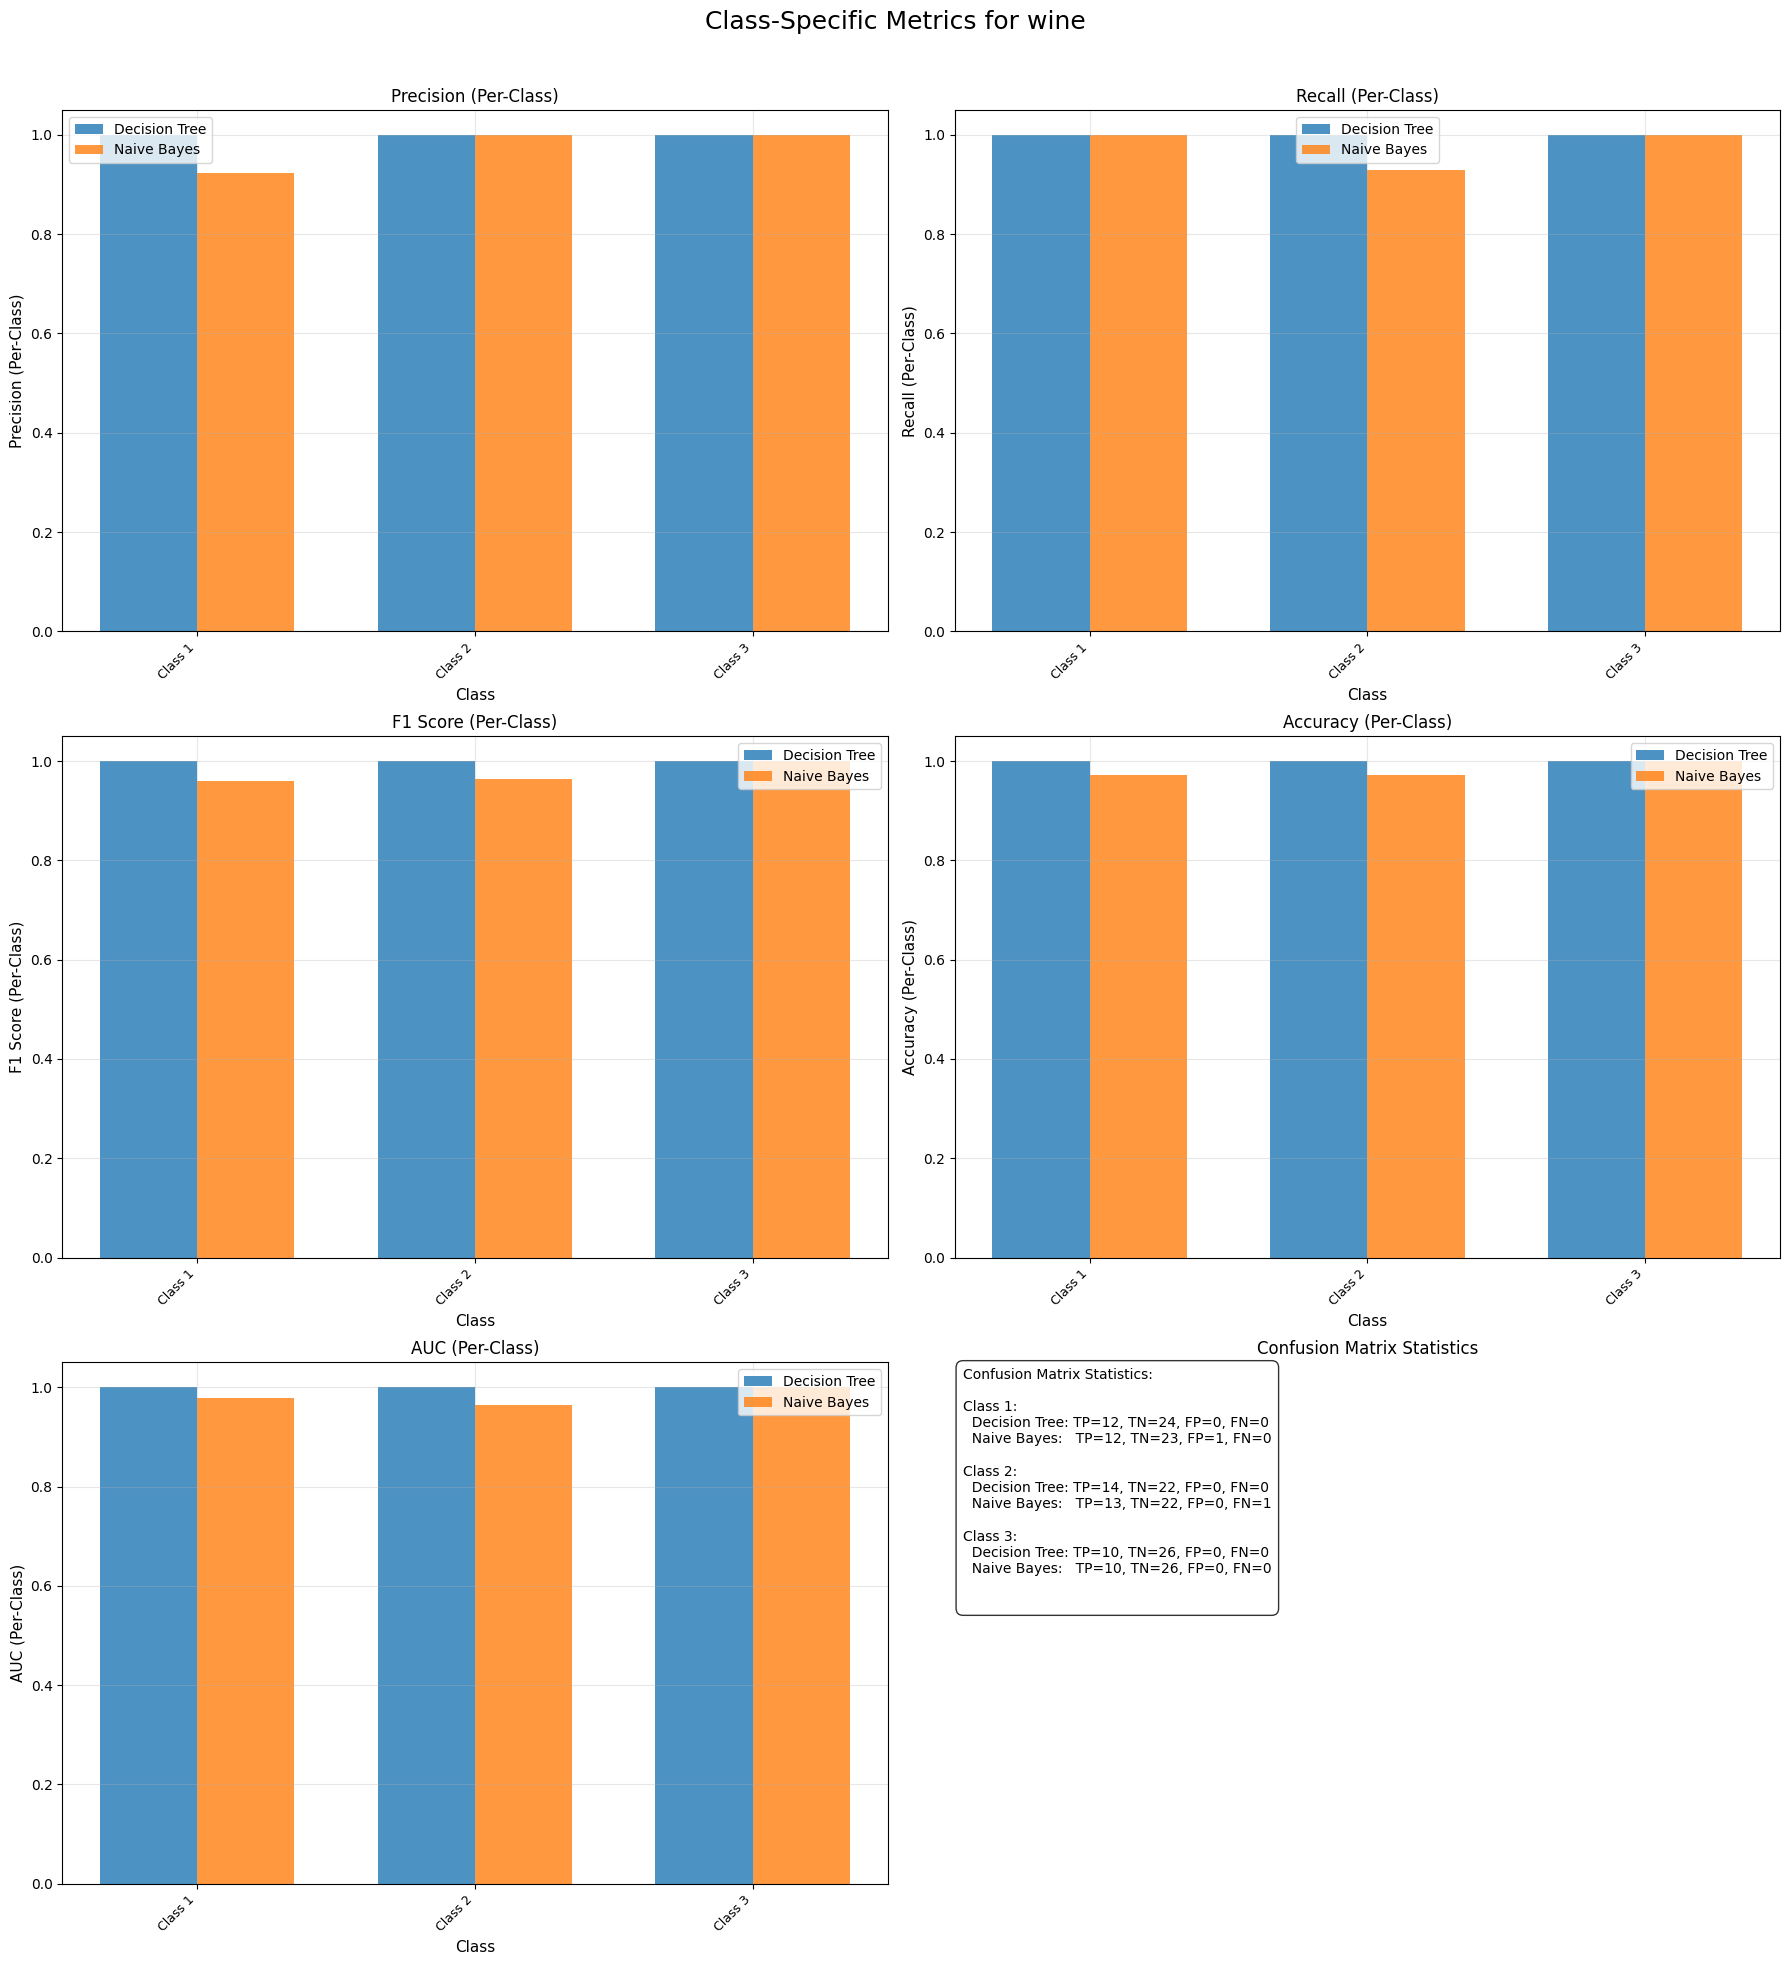

Binary ROC curves saved to 'benchmarks/roc_curves_binary.png'


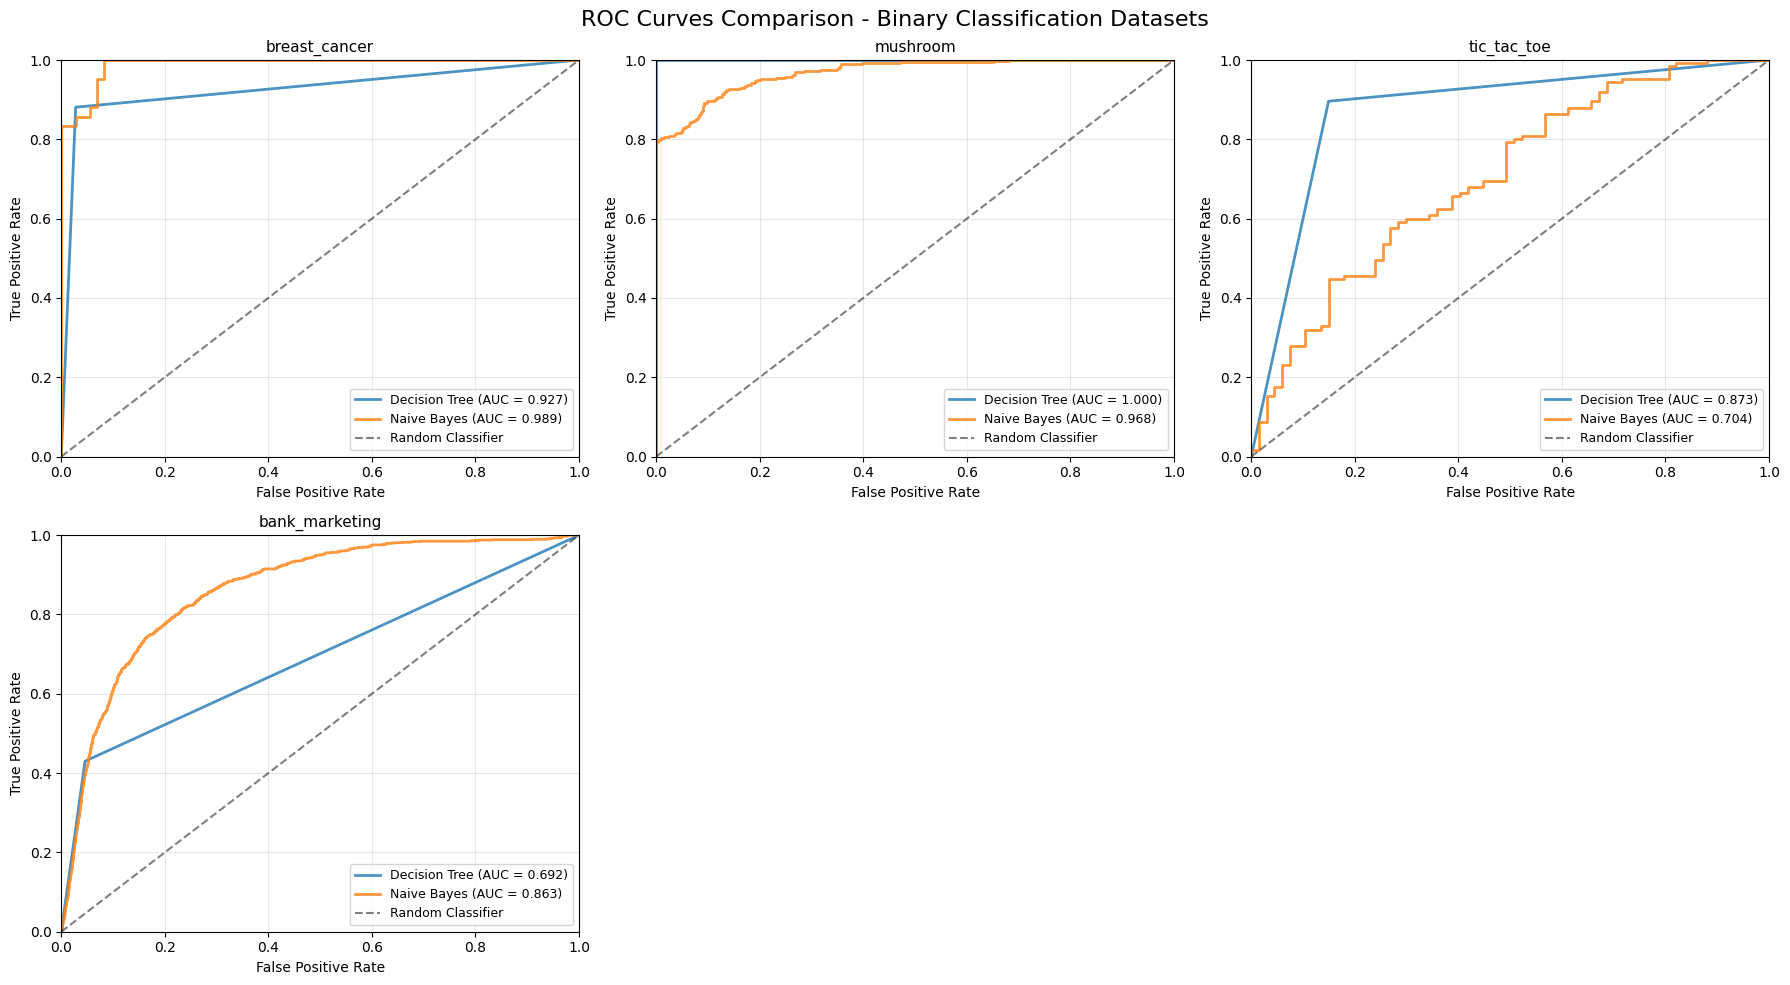

AUC comparison plot saved to 'benchmarks/auc_comparison.png'


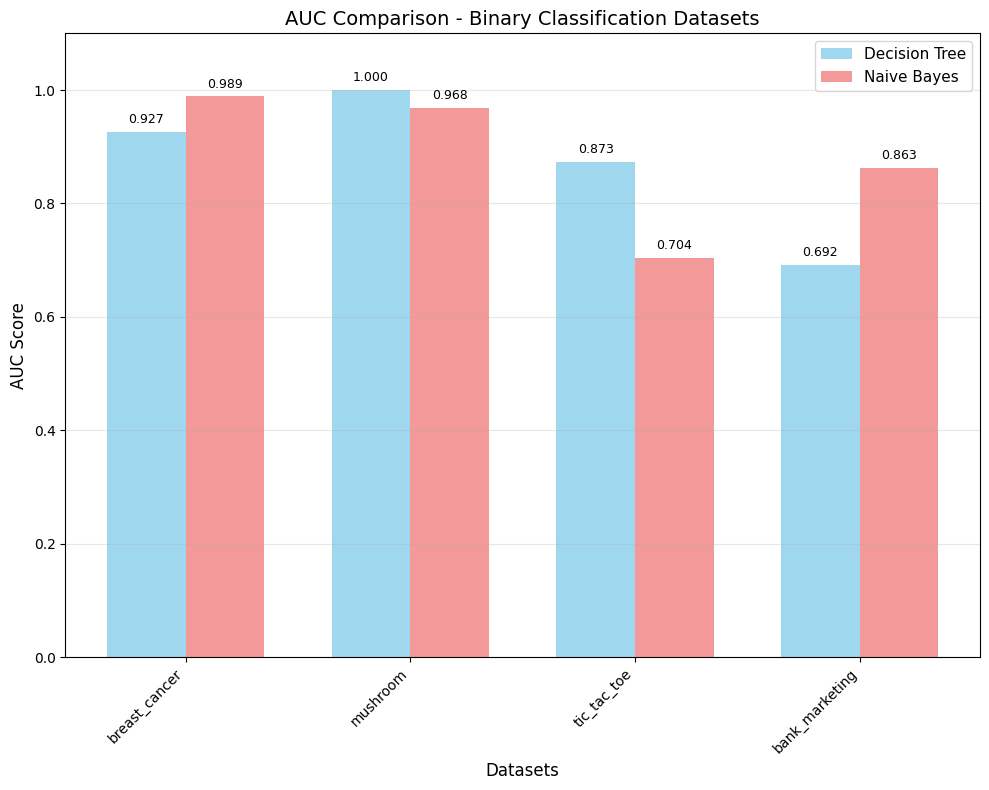


Note: 6 multi-class datasets found.
ROC curves for multi-class are complex - showing AUC scores in summary instead.
Multi-class AUC comparison plot saved to 'benchmarks/multiclass_auc_comparison_20250626_025236.png'


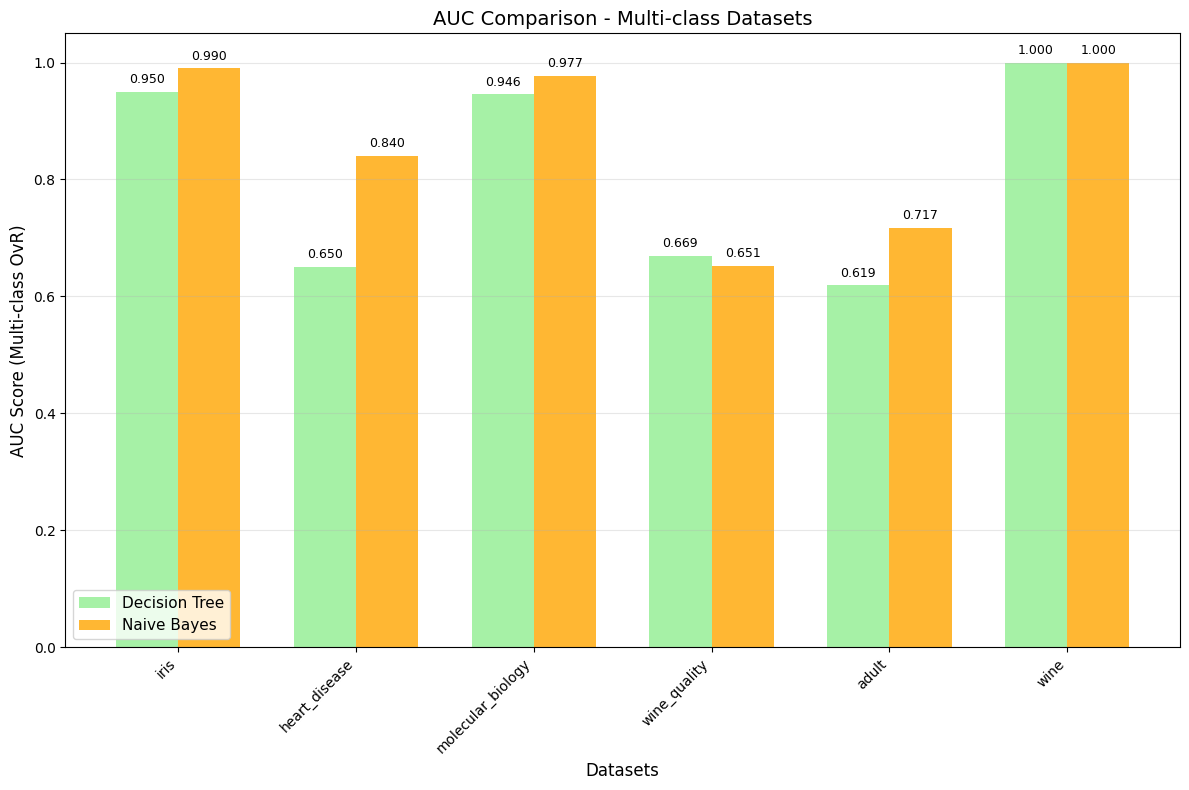


Benchmark completed!


In [18]:
if __name__ == "__main__":
    main()